# Imports

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import cmocean
from matplotlib import colors
import glidertools as gt
from datetime import datetime, timedelta
import pandas as pd
from matplotlib.dates import DateFormatter
from osufilter import osufilter
import metpy
from metpy.calc import wind_components
from metpy.units import units
import seaborn as sns

# 2022 Data

## Open Dataset

In [2]:
ds = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2022.txt/nwpo3h2022.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
ds['time'] = pd.to_datetime(ds['#yr_mo_dy_hr_mn'], format='%Y %m %d %H %M')
ds.replace('MM', np.nan, inplace=True)

ds = ds.sort_values(by=['time'])
ds = ds.reset_index(drop=True)
ds = ds.set_index(['time'])
ds = ds.drop(['sec', 'sec.1', 'hPa', 'degC.1', 'degC.2', 'ft', 'degT.1', 'm', 'm/s.1'], axis=1)

#specify path for export
path = r'C:/Users/marqjace/cui/nwpo3h2022.txt/2022_tmp.txt'

#export DataFrame to text file (keep header row and index column)
with open(path, 'w') as f:
    ds_string = ds.to_string()
    f.write(ds_string)

ds

C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\3463829803.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  ds = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2022.txt/nwpo3h2022.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\3463829803.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2022.txt/nwpo3h2022.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])


,#yr_mo_dy_hr_mn,degT,m/s,degC,mi
time,,,,,
2022-01-01 00:00:00,2022 01 01 00 00,351,6.1,6.3,99.0
2022-01-01 01:00:00,2022 01 01 01 00,4,4.4,5.6,99.0
2022-01-01 02:00:00,2022 01 01 02 00,83,2.5,3.7,99.0
2022-01-01 03:00:00,2022 01 01 03 00,92,2.5,2.7,99.0
2022-01-01 04:00:00,2022 01 01 04 00,86,3.2,1.9,99.0
...,...,...,...,...,...
2022-12-31 19:00:00,2022 12 31 19 00,190,4.4,9.5,99.0
2022-12-31 20:00:00,2022 12 31 20 00,194,4.8,9.5,99.0
2022-12-31 21:00:00,2022 12 31 21 00,218,6.1,9.6,99.0


## Create Variables

In [3]:
wdir = ds['degT'].values
wspeed = ds['m/s'].values
temp = ds['degC'].values

# # Generate a date range for 364 days starting from January 1, 2023
# start_date = '2022-01-01'
# num_days = 364

# # Use pandas to create a date range
# date_range = pd.date_range(start=start_date, periods=num_days)

# # Convert the date range to a NumPy array
# dates_array = np.array(date_range)

# # print(dates_array)

## Calculate U,V Wind Components

In [4]:
ucomp = []
vcomp = []

for dir, speed in zip(wdir, wspeed):
    u, v = metpy.calc.wind_components(speed * units('m/s'), dir * units.deg)
    ucomp.append(u.magnitude)
    vcomp.append(v.magnitude)

# Convert to DataFrame
ucomp = pd.DataFrame(ucomp, columns=['ucomp'], index=ds.index)
vcomp = pd.DataFrame(vcomp, columns=['vcomp'], index=ds.index)

ds['ucomp'] = ucomp
ds['vcomp'] = vcomp

# ds = ds.resample('D').mean(numeric_only=True)

vcomp_new = ds['vcomp']

vcomp_new

time
2022-01-01 00:00:00   -6.024899
2022-01-01 01:00:00   -4.389282
2022-01-01 02:00:00   -0.304673
2022-01-01 03:00:00    0.087249
2022-01-01 04:00:00   -0.223221
                         ...   
2022-12-31 19:00:00    4.333154
2022-12-31 20:00:00    4.657419
2022-12-31 21:00:00    4.806866
2022-12-31 22:00:00    1.458783
2022-12-31 23:00:00   -2.194061
Name: vcomp, Length: 8748, dtype: float64

## Wind Stress Calculation Function

In [5]:
kappa = 0.4  # von Karman's constant
Charnock_alpha = 0.011  # Charnock constant for open-ocean
R_roughness = 0.11  # Limiting roughness Reynolds for aerodynamically smooth flow
g = 9.8  # Acceleration due to gravity [m/s^2]

def cdn(sp, z, drag='largepond', Ta=temp):
    """Computes neutral drag coefficient and wind speed at 10 m."""
    sp, z, Ta = np.asarray(sp), np.asarray(z), np.asarray(Ta)
    tol = 0.00001

    if drag == 'largepond':
        a = np.log(z / 10.) / kappa
        u10o = np.zeros(sp.shape)
        cd = 1.15e-3 * np.ones(sp.shape)
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol

        while np.any(ii):
            u10o = u10
            cd = (4.9e-4 + 6.5e-5 * u10o)
            cd[u10o < 10.15385] = 1.15e-3
            u10 = sp / (1 + a * np.sqrt(cd))
            ii = np.abs(u10 - u10o) > tol

    elif drag == 'smith':
        visc = visc_air(Ta)
        ustaro = np.zeros(sp.shape)
        ustarn = 0.036 * sp
        ii = np.abs(ustarn - ustaro) > tol
        while np.any(ii):
            ustaro = ustarn
            z0 = Charnock_alpha * ustaro ** 2 / g + R_roughness * visc / ustaro
            ustarn = sp * (kappa / np.log(z / z0))
            ii = np.abs(ustarn - ustaro) > tol

        sqrcd = kappa / np.log(10. / z0)
        cd = sqrcd ** 2
        u10 = ustarn / sqrcd

    elif drag == 'vera':
        A = 2.717e-3
        B = 0.142e-3
        C = 0.0764e-3
        a = np.log(z / 10.) / kappa
        u10o = np.zeros(sp.shape) + 0.1
        cd = A / u10o + B + C * u10o
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol
        while np.any(ii):
            u10o = u10
            cd = A / u10o + B + C * u10o
            u10 = sp / (1 + a * np.sqrt(cd))
            ii = np.abs(u10 - u10o) > tol
    else:
        raise ValueError('Unknown method')

    return cd, u10

def stress(sp, z=10., drag='largepond', rho_air=1.22, Ta=temp):
    """Computes the neutral wind stress."""
    z, sp = np.asarray(z), np.asarray(sp)
    Ta, rho_air = np.asarray(Ta), np.asarray(rho_air)

    if drag == 'largepond':
        cd, sp = cdn(sp, z, 'largepond')
    elif drag == 'smith':
        cd, sp = cdn(sp, z, 'smith', Ta)
    elif drag == 'vera':
        cd, sp = cdn(sp, z, 'vera')
    else:
        raise ValueError('Unknown method')

    tau = rho_air * (cd * sp * np.abs(sp))

    return tau

## m/s to N/m^2

In [6]:
vcomp_N_adj = stress(vcomp_new, drag='largepond', z=18.5)
vcomp_N_raw = stress(vcomp_new, drag='largepond', z=10)

ds['stress_w_height'] = vcomp_N_adj
ds['stress_raw'] = vcomp_N_raw

ds = ds.resample('D').mean(numeric_only=True)

ds['stress_w_height'] = np.round(ds['stress_w_height'], 3)
ds['stress_raw'] = np.round(ds['stress_raw'], 3)

stress_w_height = ds['stress_w_height']
stress_raw = ds['stress_raw']

# vcomp_N = pd.DataFrame(vcomp_N, columns=['vcomp'])
# vcomp_N = vcomp_N.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()
# vcomp_N = np.array(vcomp_N, dtype='float32')

ds

,degT,m/s,degC,mi,ucomp,vcomp,stress_w_height,stress_raw
time,,,,,,,,
2022-01-01,98.833333,4.058333,2.316667,99.0,-3.433701,-0.486516,-0.003,-0.003
2022-01-02,133.583333,6.933333,5.654167,99.0,-1.913136,5.289701,0.096,0.110
2022-01-03,218.958333,15.220833,8.370833,99.0,7.243991,11.480733,0.370,0.439
2022-01-04,222.833333,8.670833,7.833333,99.0,5.781141,5.961598,0.050,0.056
2022-01-05,196.541667,3.875000,8.283333,99.0,1.085781,1.287177,0.016,0.018
...,...,...,...,...,...,...,...,...
2022-12-27,194.625000,16.037500,11.666667,99.0,5.642531,13.701266,0.368,0.430
2022-12-28,234.625000,8.108333,9.212500,99.0,6.140554,4.038388,0.029,0.032
2022-12-29,151.916667,6.733333,8.550000,99.0,-0.560193,5.740485,0.075,0.086


## Plots (w/ Height Adjustment)

Text(0.5, 1.0, '2022 (w/ Height Adjustment)')

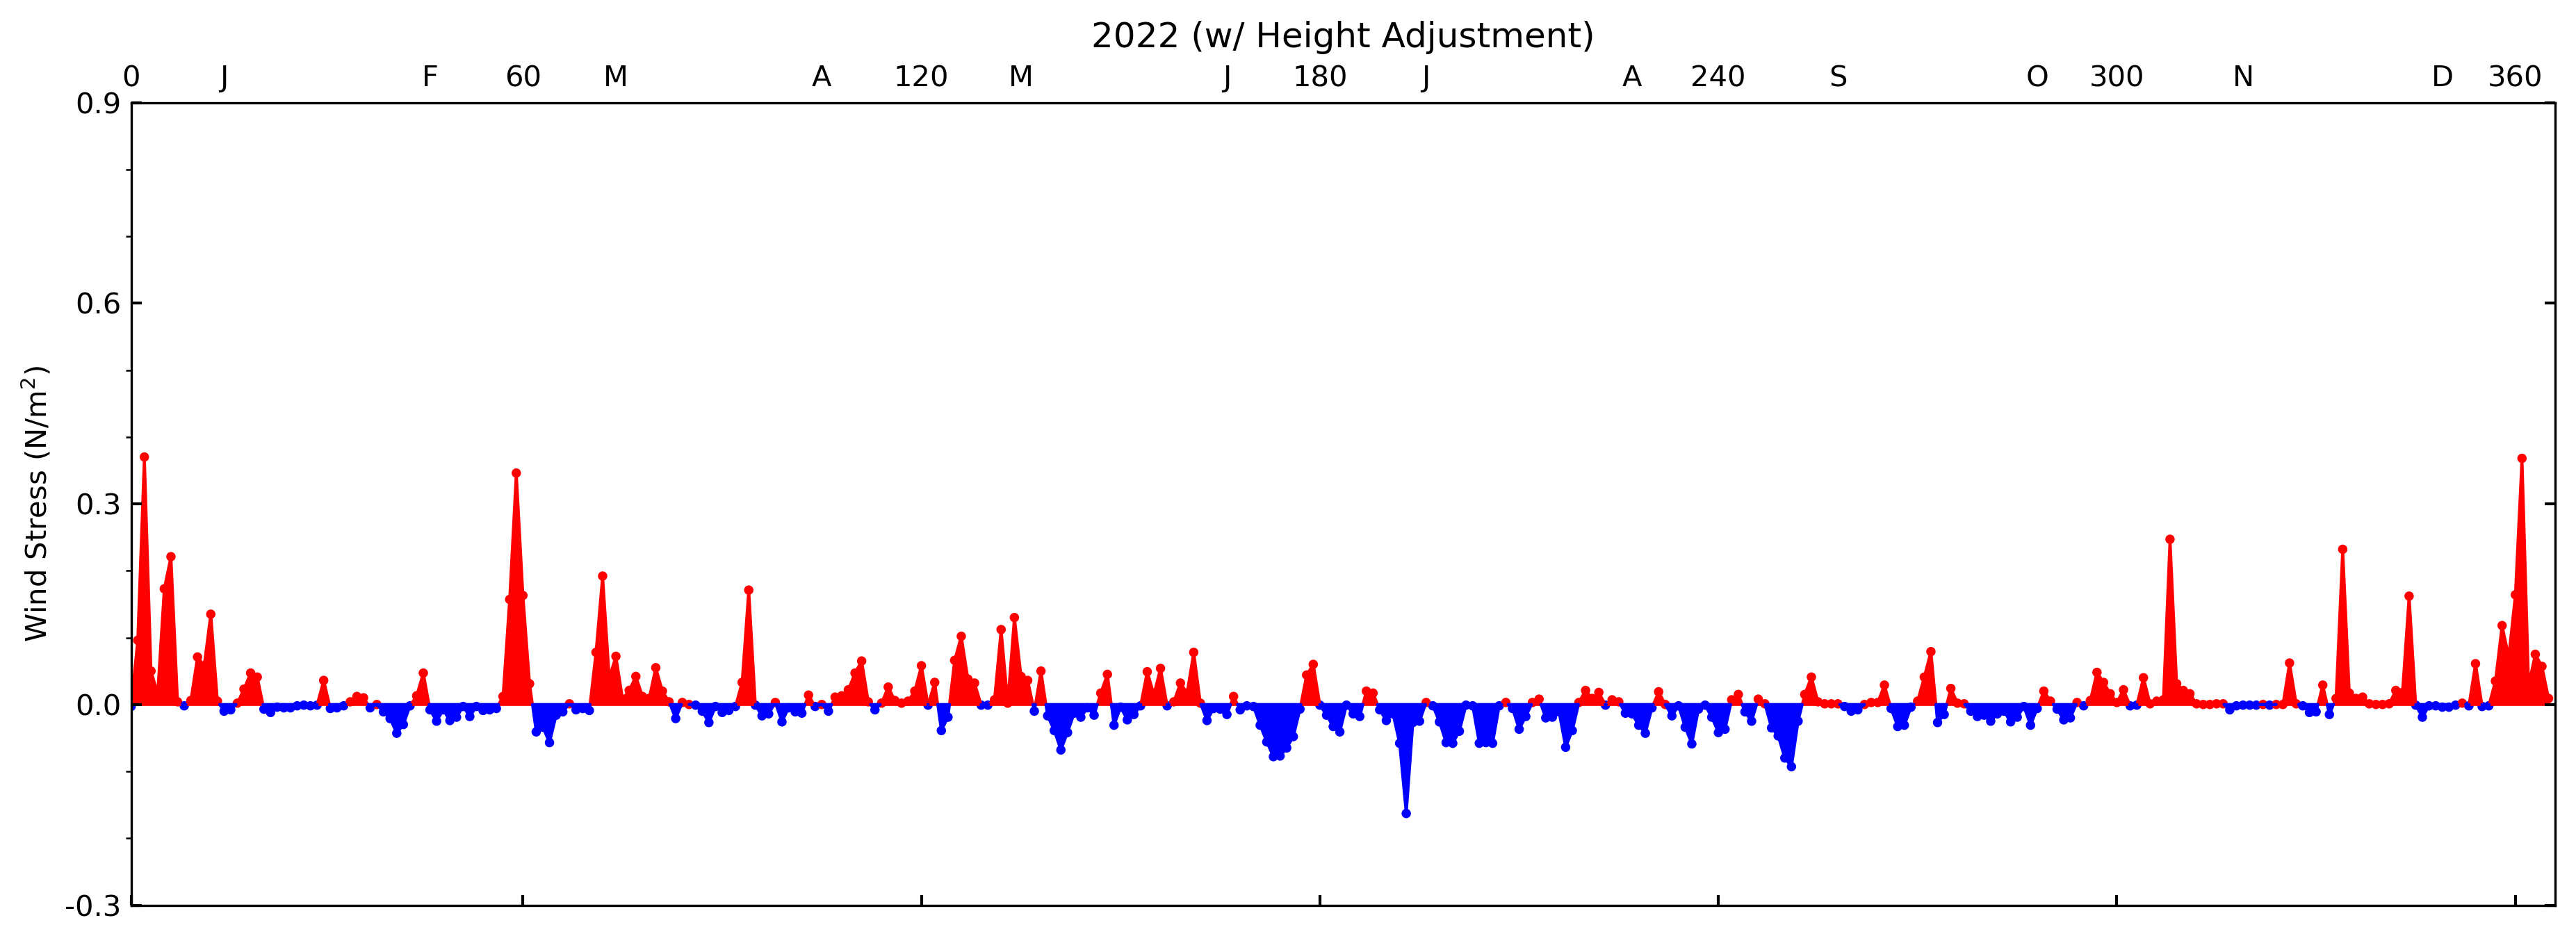

In [7]:
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax.scatter(ds.index, stress_w_height, c=colors, s=5)

# Fill the area under the curve
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax.set_xticklabels('')
ax.set_xticks((datetime(2022,1,15), datetime(2022,2,15), datetime(2022,3,15), datetime(2022,4,15), datetime(2022,5,15), datetime(2022,6,15), datetime(2022,7,15), 
            datetime(2022,8,15), datetime(2022,9,15), datetime(2022,10,15), datetime(2022,11,15), datetime(2022,12,15)), minor=True)
ax.set_xticks((datetime(2022,1,1), datetime(2022,3,1), datetime(2022,4,30), datetime(2022,6,29), datetime(2022,8,28), datetime(2022,10,27), datetime(2022,12,26)))
ax.set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'), minor=True)
ax.set_xticklabels(('0', '60', '120', '180', '240', '300', '360'))
ax.set_xlim(datetime(2022,1,1), datetime(2023,1,1))
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(width=1, top=False, right=True, bottom=True, direction='in', which='major')

# Remove minor tick labels
ax.tick_params(axis='x', which='minor', length=0)

# Set x-axis label position to top
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Turn off major ticks at the top
ax.tick_params(axis='x', which='major', top=False)

# Turn on major ticks at the bottom
ax.tick_params(axis='x', which='major', bottom=True, direction='in')

ax.set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_yticks((-0.2, -0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8), minor=True)
ax.set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_ylim(-0.3, 0.9)

ax.set_ylabel(r'Wind Stress (N/m$^2$)')
ax.set_title('2022 (w/ Height Adjustment)')

In [8]:
# Correctly filter the time range
start_date = np.datetime64('2022-05-18T00:00:00.000000000')
end_date = np.datetime64('2022-10-10T00:00:00.000000000')

mask = np.logical_and(ds.index >= start_date, ds.index <= end_date)

new_time2 = ds.index[mask]
new_vcomp_N2 = stress_w_height[mask]
# cumulative_sum2 = (np.cumsum(new_vcomp_N2)) * 1.6325
cumulative_sum_adj = (np.cumsum(new_vcomp_N2))


# cumulative_sum2 = pd.DataFrame(cumulative_sum2)
# cumulative_sum2 = cumulative_sum2.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()

cumsum_min_adj = cumulative_sum_adj.min()
cumsum_min_adj = round(cumsum_min_adj, 3)
cumsum_min_adj = str(cumsum_min_adj)

print(cumsum_min_adj)

-1.737


Text(0.5, 1.0, '2022 (w/ Height Adjustment)')

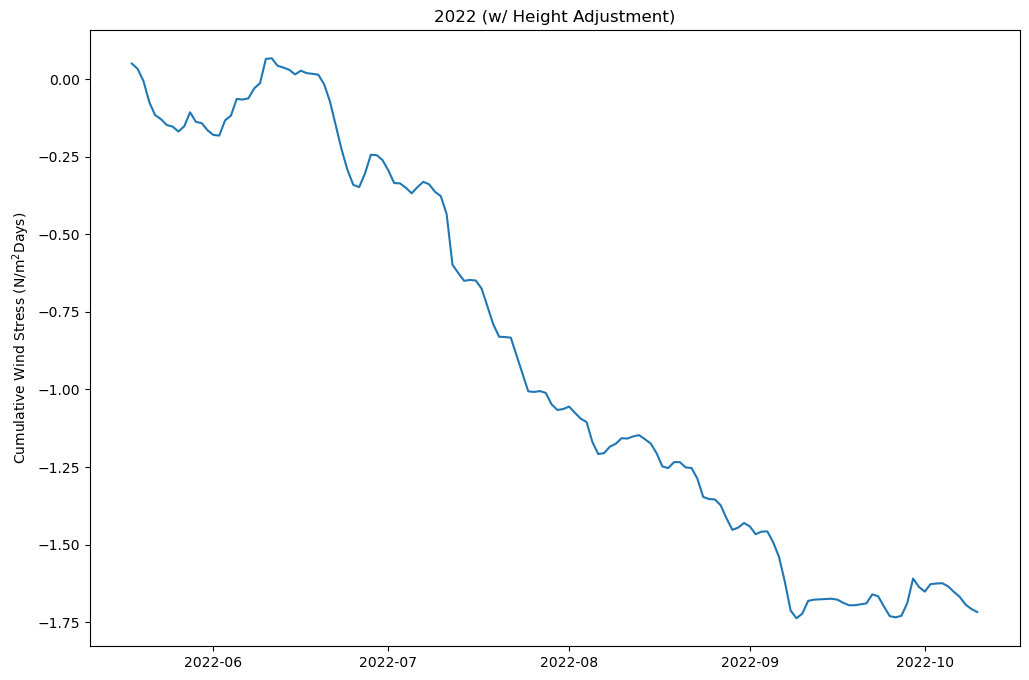

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(new_time2, cumulative_sum_adj)

ax.set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
ax.set_title('2022 (w/ Height Adjustment)')

Text(2022-10-15 00:00:00, -1.9869999999999999, '-2.083 N/$m^2$Days (Steve)')

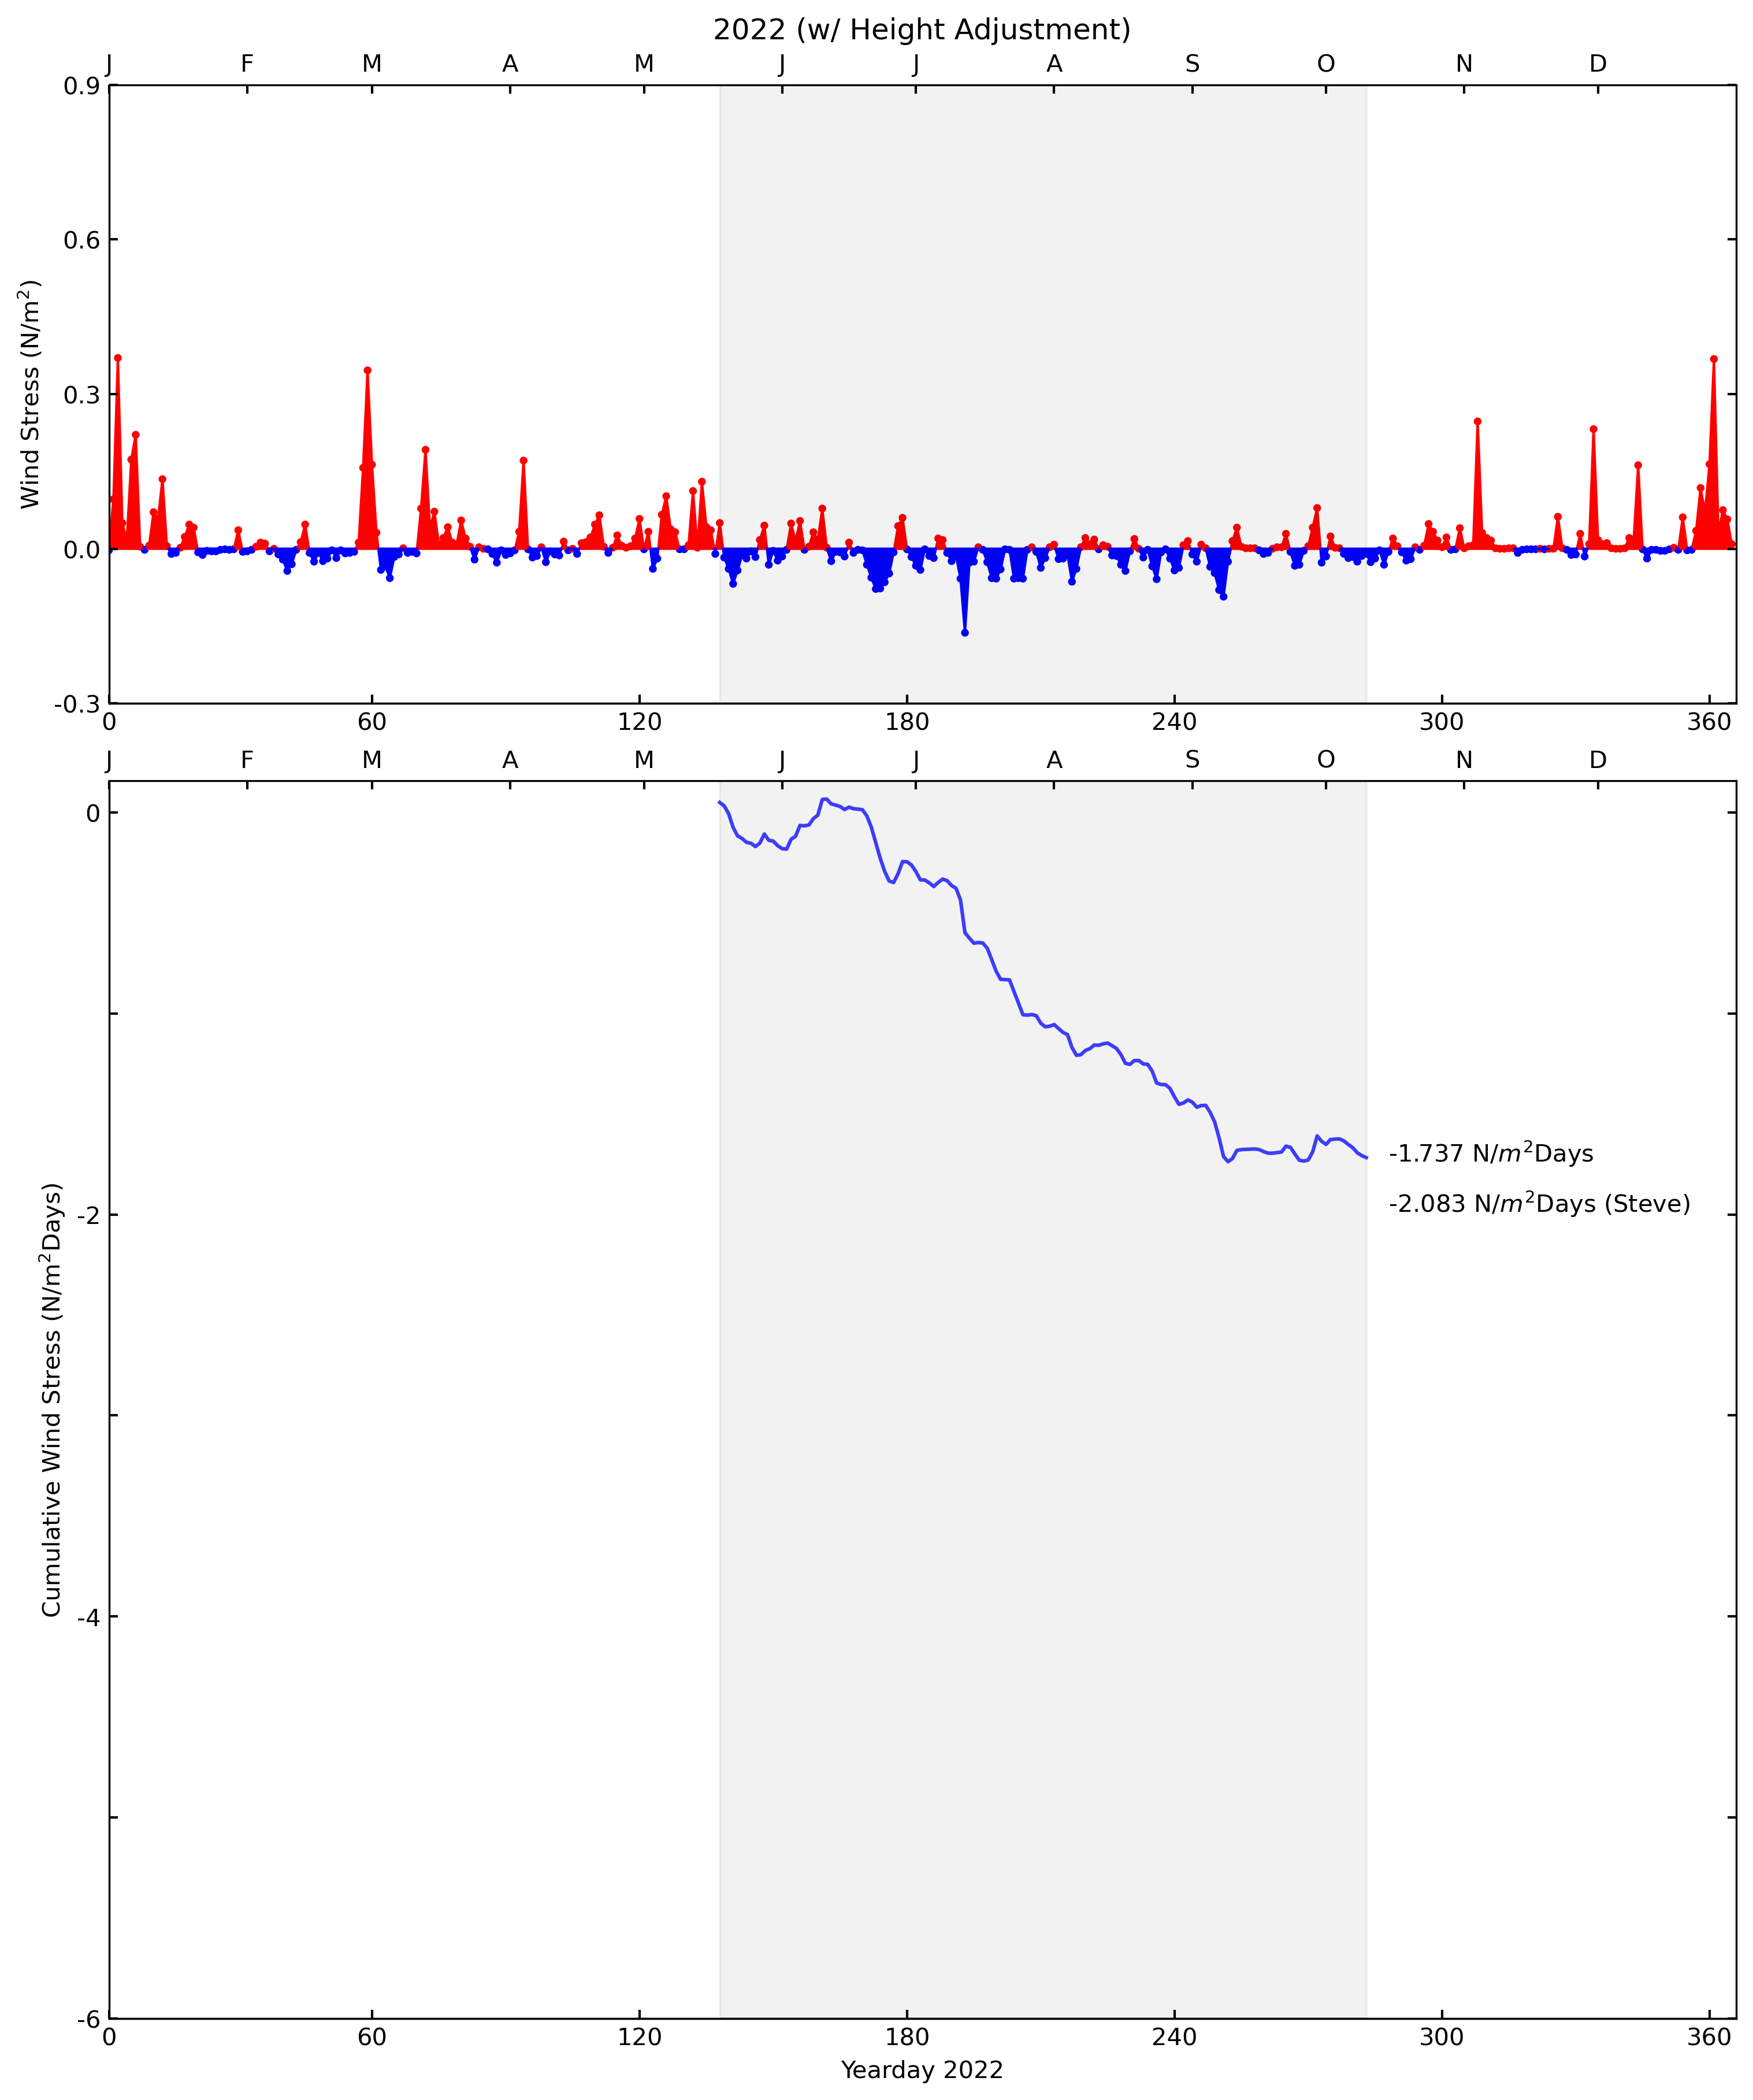

In [10]:
fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                               ['lower', 'lower', 'lower'],
                                     ['lower', 'lower', 'lower']],
                              figsize=(10, 12), layout="constrained", dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax['upper'].scatter(ds.index, stress_w_height, c=colors.ravel(), s=5)

stress = np.ravel(stress)

# Fill the area under the curve
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax['upper'].set_xticklabels('')
ax['upper'].set_xticks((datetime(2022,1,1), datetime(2022,2,1), datetime(2022,3,1), datetime(2022,4,1), datetime(2022,5,1), datetime(2022,6,1), datetime(2022,7,1), 
            datetime(2022,8,1), datetime(2022,9,1), datetime(2022,10,1), datetime(2022,11,1), datetime(2022,12,1)))
ax['upper'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['upper'].set_xlim(datetime(2022,1,1), datetime(2023,1,1))
ax['upper'].xaxis.set_label_position('top') 
ax['upper'].xaxis.tick_top()
ax['upper'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax['upper'].secondary_xaxis(location=0)
sec.set_xticks([datetime(2022,1,1), datetime(2022,3,1), datetime(2022,4,30), datetime(2022,6,29), datetime(2022,8,28), datetime(2022,10,27), datetime(2022,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_ylim(-0.3, 0.9)

ax['upper'].set_ylabel(r'Wind Stress (N/m$^2$)')
ax['upper'].set_title('2022 (w/ Height Adjustment)')

ax['lower'].plot(new_time2, cumulative_sum_adj, c='b', alpha=0.75)
ax['lower'].set_xticklabels('')
ax['lower'].set_xticks((datetime(2022,1,1), datetime(2022,2,1), datetime(2022,3,1), datetime(2022,4,1), datetime(2022,5,1), datetime(2022,6,1), datetime(2022,7,1), 
            datetime(2022,8,1), datetime(2022,9,1), datetime(2022,10,1), datetime(2022,11,1), datetime(2022,12,1)))
ax['lower'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['lower'].set_xlim(datetime(2022,1,1), datetime(2023,1,1))
ax['lower'].xaxis.set_label_position('top') 
ax['lower'].xaxis.tick_top()
ax['lower'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')
ax['lower'].set_yticks((0, -1, -2, -3, -4, -5, -6))
ax['lower'].set_yticklabels(('0', '', '-2', '', '-4', '', '-6'))

sec2 = ax['lower'].secondary_xaxis(location=0)
sec2.set_xticks([datetime(2022,1,1), datetime(2022,3,1), datetime(2022,4,30), datetime(2022,6,29), datetime(2022,8,28), datetime(2022,10,27), datetime(2022,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec2.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].axvspan(xmin=datetime(2022,5,18), xmax=datetime(2022,10,10), color='k', alpha=0.05)
ax['lower'].axvspan(xmin=datetime(2022,5,18), xmax=datetime(2022,10,10), color='k', alpha=0.05)

ax['lower'].set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
sec2.set_xlabel(r'Yearday 2022')

ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_adj.min(), cumsum_min_adj + ' ' + r'N/$m^2$Days')
ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_adj.min() - 0.25, '-2.083' + ' ' + r"N/$m^2$Days (Steve)")

## Plots (raw)

Text(0.5, 1.0, '2022 (raw)')

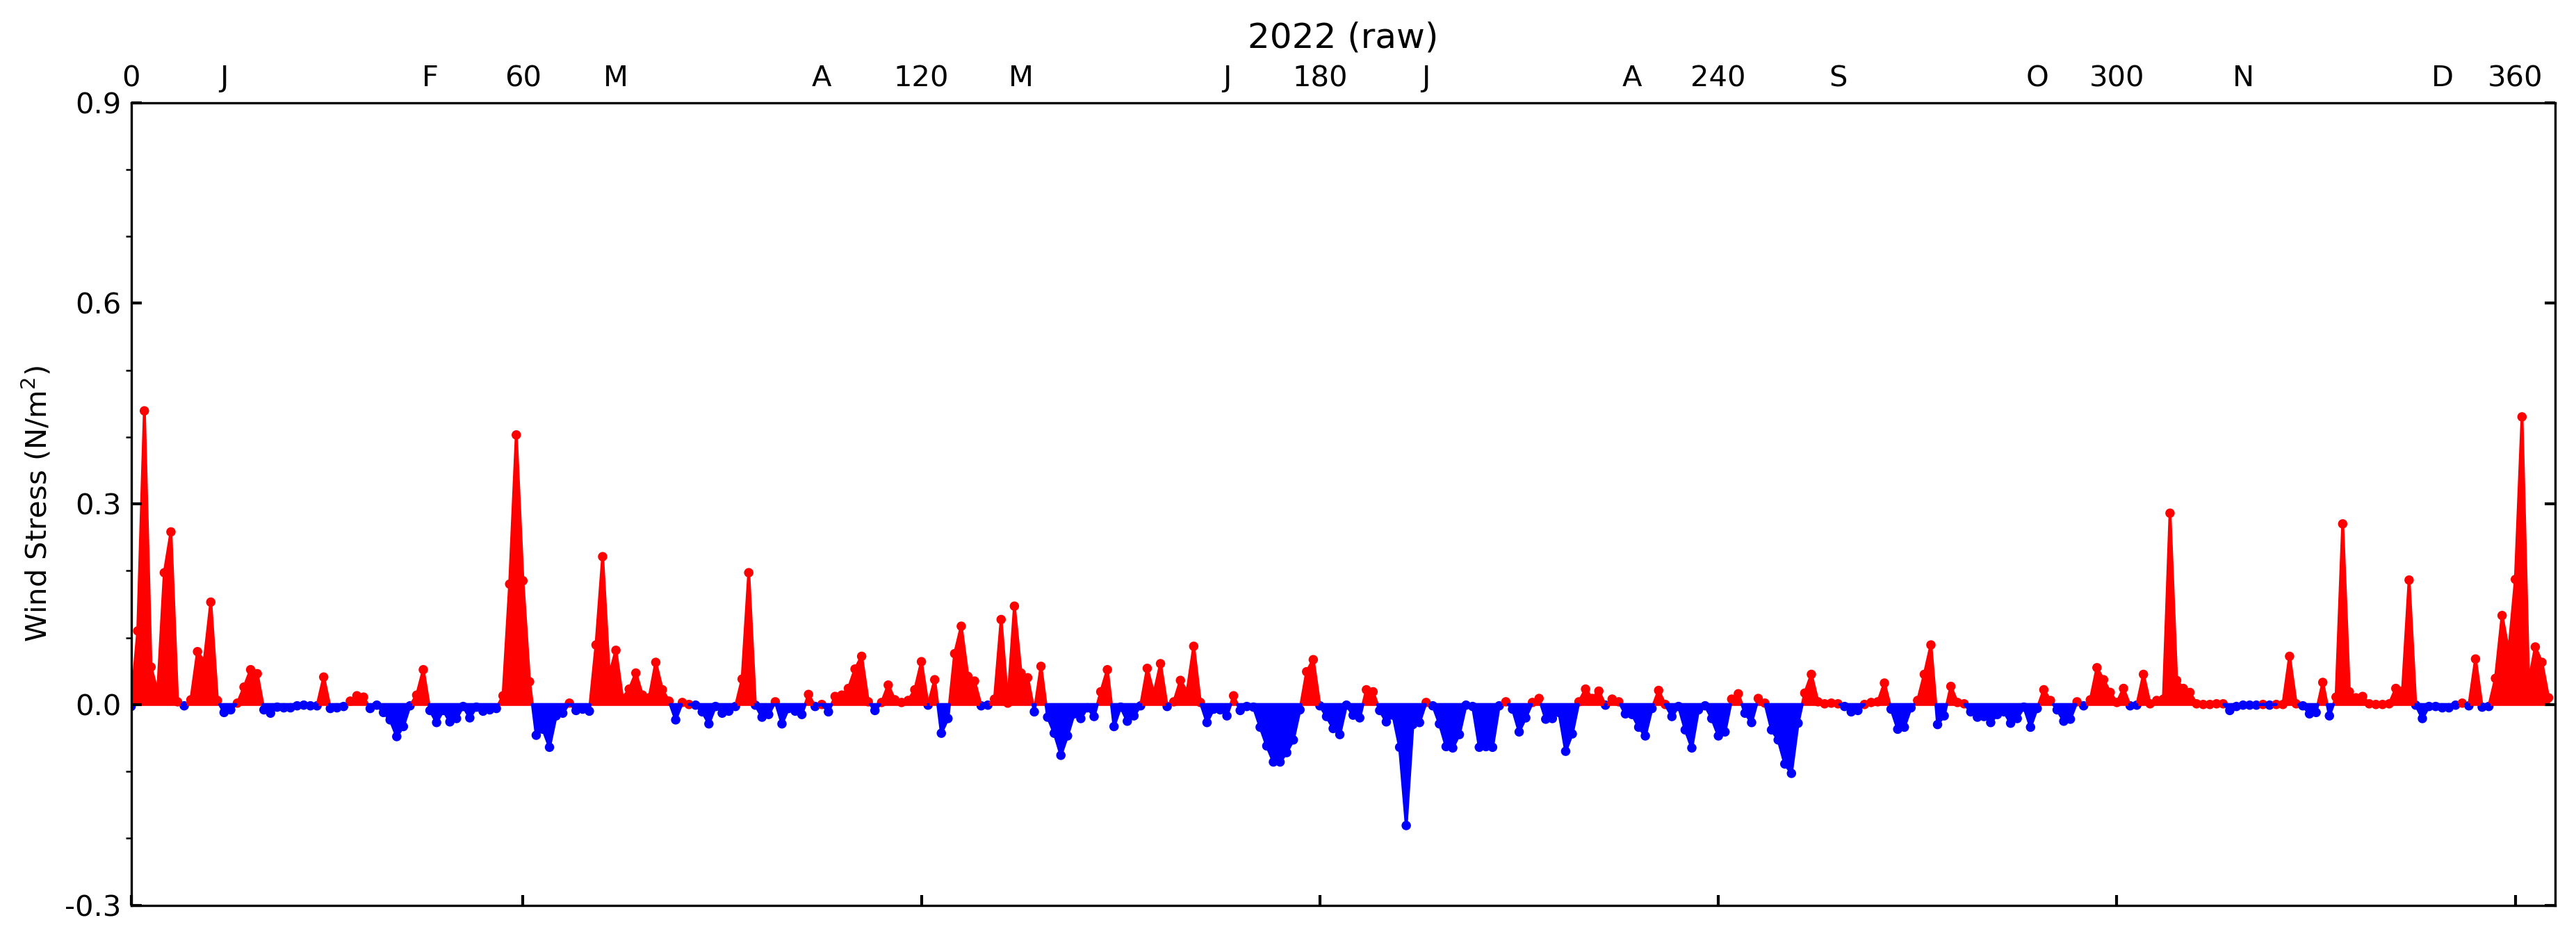

In [11]:
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

colors = c=np.where(stress_raw<0, 'b', 'r')
ax.scatter(ds.index, stress_raw, c=colors, s=5)

# Fill the area under the curve
ax.fill_between(ds.index, stress_raw, where=(stress_raw >= 0), interpolate=True, color='r', alpha=1)
ax.fill_between(ds.index, stress_raw, where=(stress_raw < 0), interpolate=True, color='b', alpha=1)

ax.set_xticklabels('')
ax.set_xticks((datetime(2022,1,15), datetime(2022,2,15), datetime(2022,3,15), datetime(2022,4,15), datetime(2022,5,15), datetime(2022,6,15), datetime(2022,7,15), 
            datetime(2022,8,15), datetime(2022,9,15), datetime(2022,10,15), datetime(2022,11,15), datetime(2022,12,15)), minor=True)
ax.set_xticks((datetime(2022,1,1), datetime(2022,3,1), datetime(2022,4,30), datetime(2022,6,29), datetime(2022,8,28), datetime(2022,10,27), datetime(2022,12,26)))
ax.set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'), minor=True)
ax.set_xticklabels(('0', '60', '120', '180', '240', '300', '360'))
ax.set_xlim(datetime(2022,1,1), datetime(2023,1,1))
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(width=1, top=False, right=True, bottom=True, direction='in', which='major')

# Remove minor tick labels
ax.tick_params(axis='x', which='minor', length=0)

# Set x-axis label position to top
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Turn off major ticks at the top
ax.tick_params(axis='x', which='major', top=False)

# Turn on major ticks at the bottom
ax.tick_params(axis='x', which='major', bottom=True, direction='in')

ax.set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_yticks((-0.2, -0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8), minor=True)
ax.set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_ylim(-0.3, 0.9)

ax.set_ylabel(r'Wind Stress (N/m$^2$)')
ax.set_title('2022 (raw)')

In [12]:
# Correctly filter the time range
start_date = np.datetime64('2022-05-18T00:00:00.000000000')
end_date = np.datetime64('2022-10-10T00:00:00.000000000')

mask = np.logical_and(ds.index >= start_date, ds.index <= end_date)

new_time2 = ds.index[mask]
new_vcomp_N2 = stress_raw[mask]
# cumulative_sum2 = (np.cumsum(new_vcomp_N2)) * 1.6325
cumulative_sum_raw = (np.cumsum(new_vcomp_N2))


# cumulative_sum2 = pd.DataFrame(cumulative_sum2)
# cumulative_sum2 = cumulative_sum2.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()

cumsum_min_raw = cumulative_sum_raw.min()
cumsum_min_raw = round(cumsum_min_raw, 3)
cumsum_min_raw = str(cumsum_min_raw)

print(cumsum_min_raw)

-1.922


Text(0.5, 1.0, '2022 (raw)')

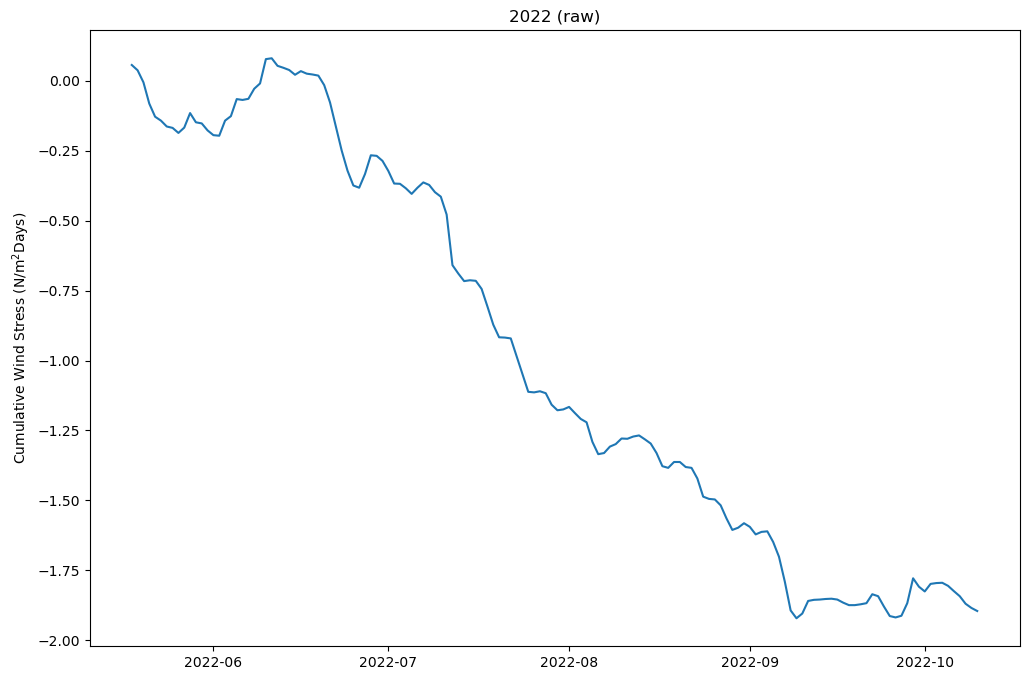

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(new_time2, cumulative_sum_raw)

ax.set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
ax.set_title('2022 (raw)')

Text(2022-10-15 00:00:00, -2.1719999999999997, '-2.083 N/$m^2$Days (Steve)')

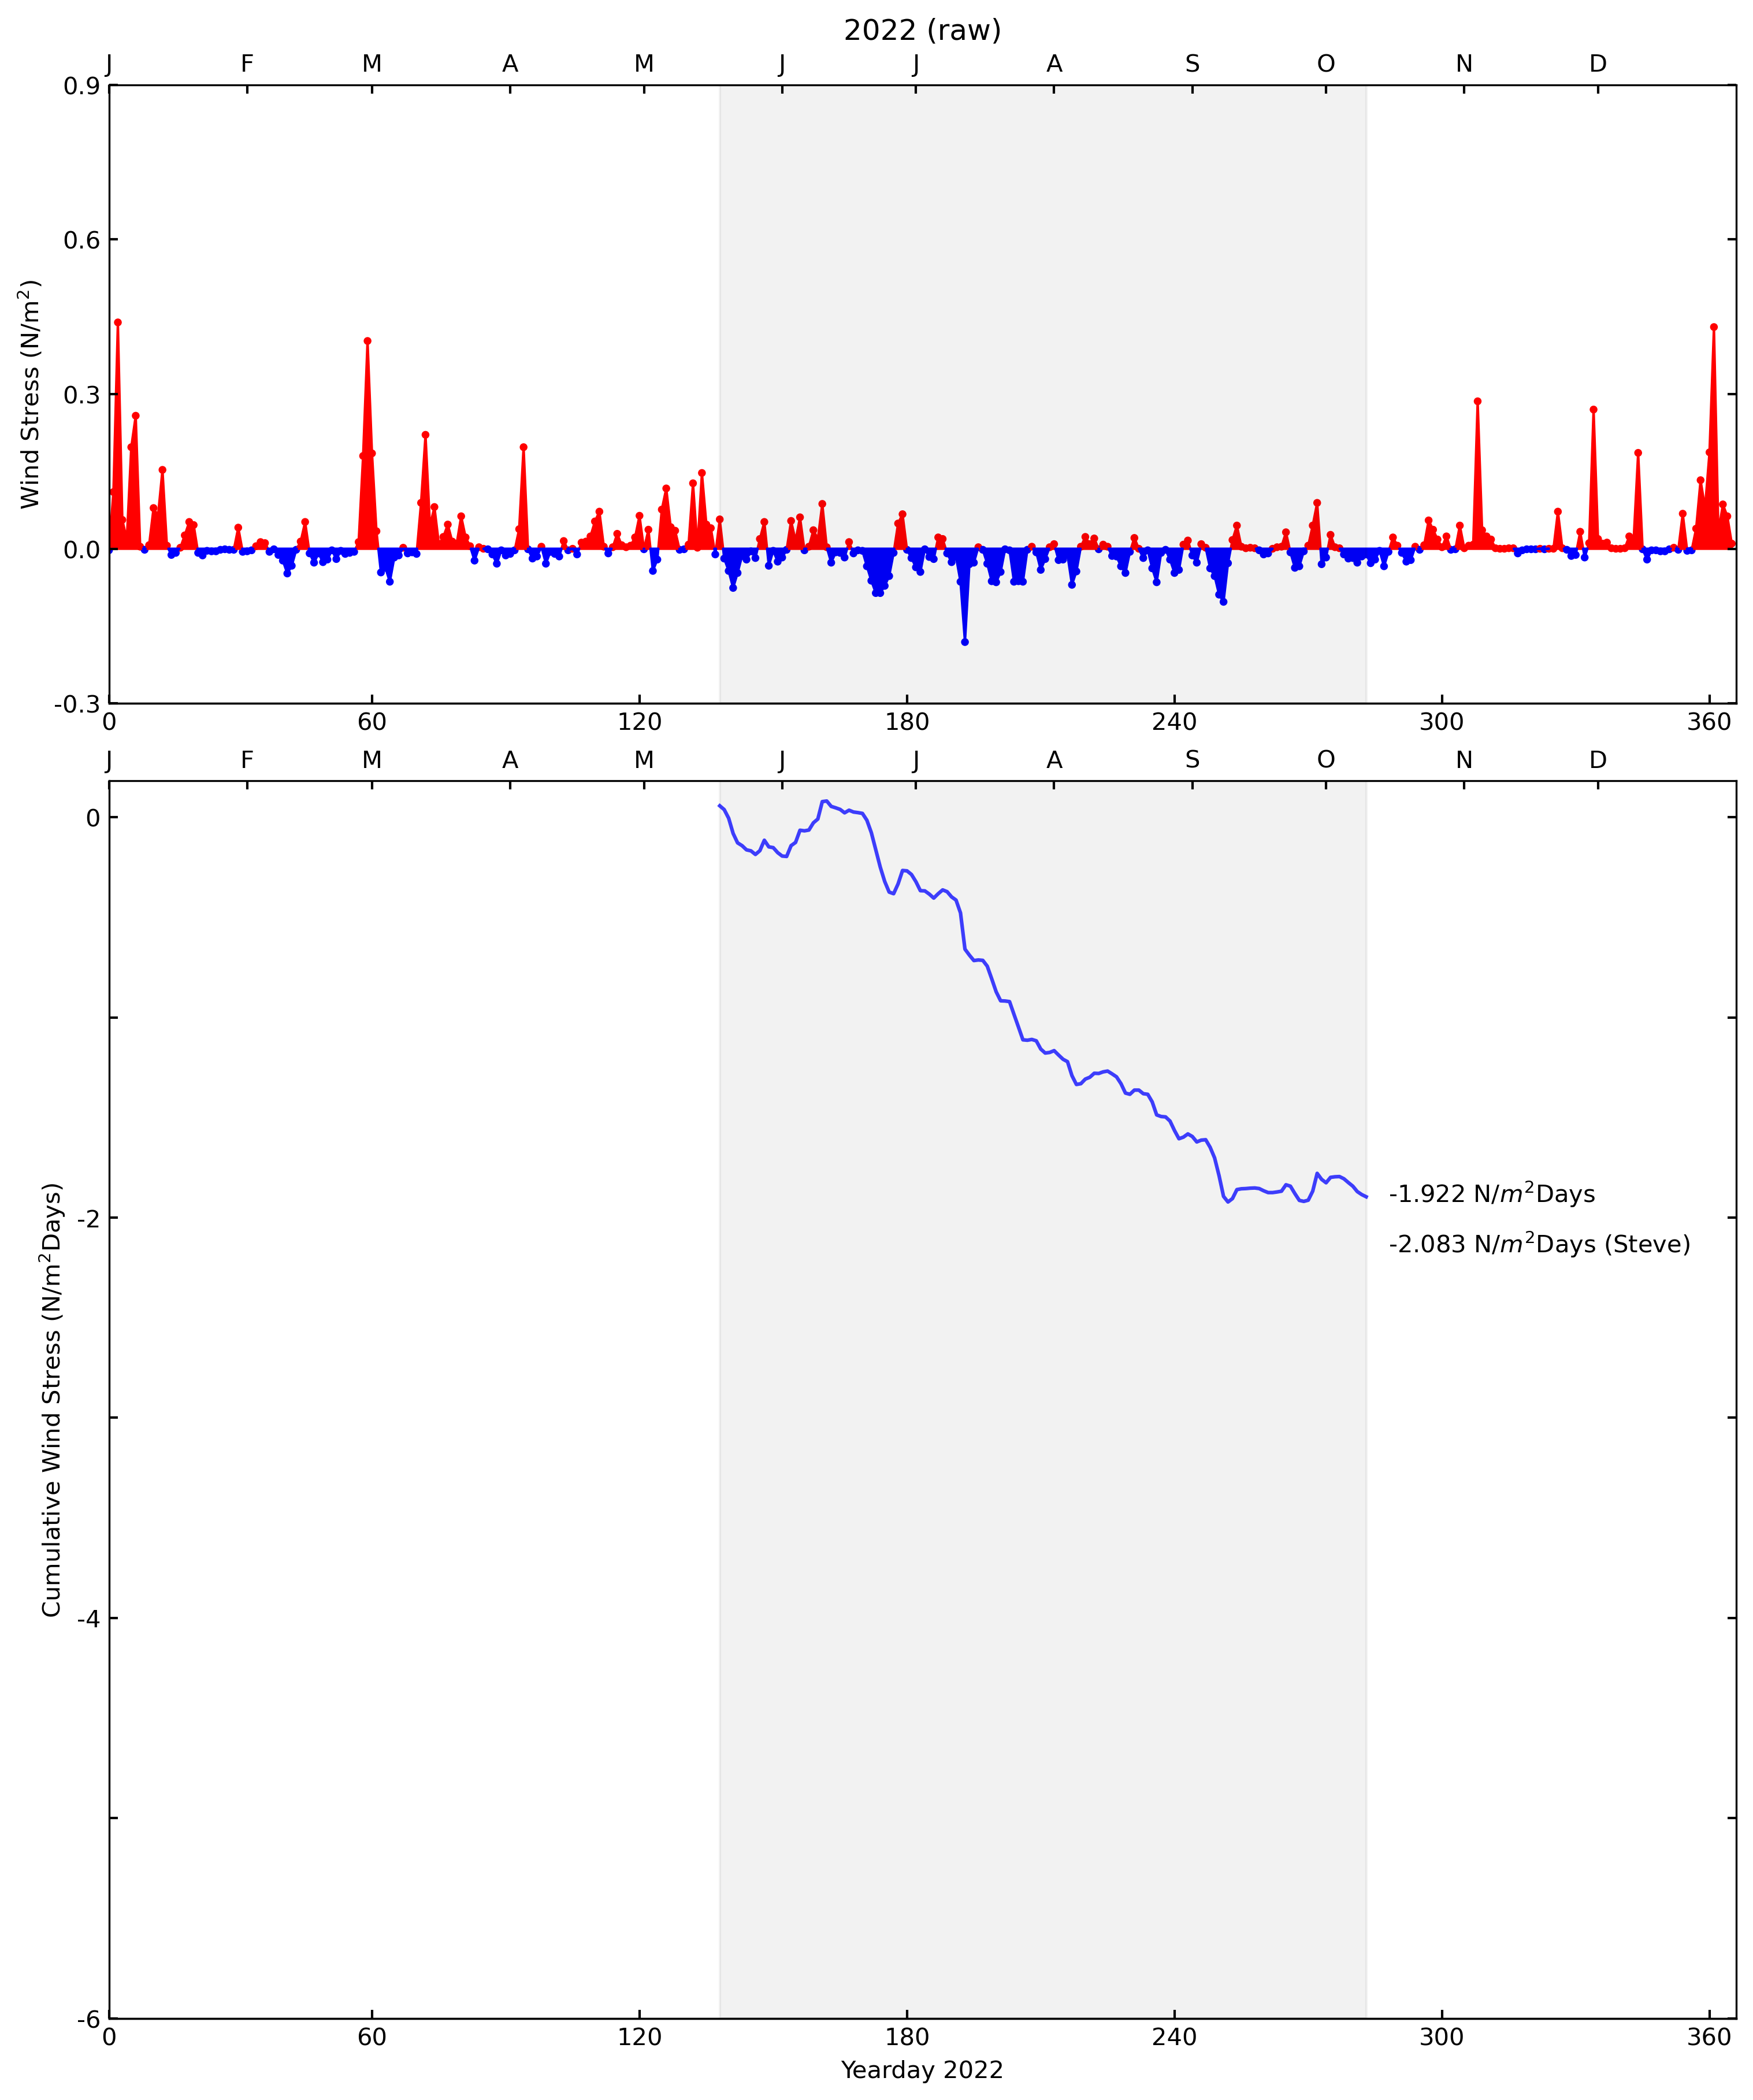

In [14]:
fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                               ['lower', 'lower', 'lower'],
                                     ['lower', 'lower', 'lower']],
                              figsize=(10, 12), layout="constrained", dpi=300)

colors = c=np.where(stress_raw<0, 'b', 'r')
ax['upper'].scatter(ds.index, stress_raw, c=colors.ravel(), s=5)

stress = np.ravel(stress)

# Fill the area under the curve
ax['upper'].fill_between(ds.index, stress_raw, where=(stress_raw >= 0), interpolate=True, color='r', alpha=1)
ax['upper'].fill_between(ds.index, stress_raw, where=(stress_raw < 0), interpolate=True, color='b', alpha=1)

ax['upper'].set_xticklabels('')
ax['upper'].set_xticks((datetime(2022,1,1), datetime(2022,2,1), datetime(2022,3,1), datetime(2022,4,1), datetime(2022,5,1), datetime(2022,6,1), datetime(2022,7,1), 
            datetime(2022,8,1), datetime(2022,9,1), datetime(2022,10,1), datetime(2022,11,1), datetime(2022,12,1)))
ax['upper'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['upper'].set_xlim(datetime(2022,1,1), datetime(2023,1,1))
ax['upper'].xaxis.set_label_position('top') 
ax['upper'].xaxis.tick_top()
ax['upper'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax['upper'].secondary_xaxis(location=0)
sec.set_xticks([datetime(2022,1,1), datetime(2022,3,1), datetime(2022,4,30), datetime(2022,6,29), datetime(2022,8,28), datetime(2022,10,27), datetime(2022,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_ylim(-0.3, 0.9)

ax['upper'].set_ylabel(r'Wind Stress (N/m$^2$)')
ax['upper'].set_title('2022 (raw)')

ax['lower'].plot(new_time2, cumulative_sum_raw, c='b', alpha=0.75)
ax['lower'].set_xticklabels('')
ax['lower'].set_xticks((datetime(2022,1,1), datetime(2022,2,1), datetime(2022,3,1), datetime(2022,4,1), datetime(2022,5,1), datetime(2022,6,1), datetime(2022,7,1), 
            datetime(2022,8,1), datetime(2022,9,1), datetime(2022,10,1), datetime(2022,11,1), datetime(2022,12,1)))
ax['lower'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['lower'].set_xlim(datetime(2022,1,1), datetime(2023,1,1))
ax['lower'].xaxis.set_label_position('top') 
ax['lower'].xaxis.tick_top()
ax['lower'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')
ax['lower'].set_yticks((0, -1, -2, -3, -4, -5, -6))
ax['lower'].set_yticklabels(('0', '', '-2', '', '-4', '', '-6'))

sec2 = ax['lower'].secondary_xaxis(location=0)
sec2.set_xticks([datetime(2022,1,1), datetime(2022,3,1), datetime(2022,4,30), datetime(2022,6,29), datetime(2022,8,28), datetime(2022,10,27), datetime(2022,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec2.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].axvspan(xmin=datetime(2022,5,18), xmax=datetime(2022,10,10), color='k', alpha=0.05)
ax['lower'].axvspan(xmin=datetime(2022,5,18), xmax=datetime(2022,10,10), color='k', alpha=0.05)

ax['lower'].set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
sec2.set_xlabel(r'Yearday 2022')

ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_raw.min(), cumsum_min_raw + ' ' + r'N/$m^2$Days')
ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_raw.min() - 0.25, '-2.083' + ' ' + r"N/$m^2$Days (Steve)")

# 2023 Data

## Open Dataset

In [15]:
ds = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2023.txt/nwpo3h2023.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
ds['time'] = pd.to_datetime(ds['#yr_mo_dy_hr_mn'], format='%Y %m %d %H %M')
ds.replace('MM', np.nan, inplace=True)

ds = ds.sort_values(by=['time'])
ds = ds.reset_index(drop=True)
ds = ds.set_index(['time'])
ds = ds.drop(['sec', 'sec.1', 'hPa', 'degC.1', 'degC.2', 'ft', 'degT.1', 'm', 'm/s.1'], axis=1)

#specify path for export
path = r'C:/Users/marqjace/cui/nwpo3h2023.txt/2023_tmp.txt'

#export DataFrame to text file (keep header row and index column)
with open(path, 'w') as f:
    ds_string = ds.to_string()
    f.write(ds_string)

ds

C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\2479457510.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  ds = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2023.txt/nwpo3h2023.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\2479457510.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2023.txt/nwpo3h2023.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])


,#yr_mo_dy_hr_mn,degT,m/s,degC,mi
time,,,,,
2023-01-01 00:00:00,2023 01 01 00 00,321,5.6,9.4,99.0
2023-01-01 01:00:00,2023 01 01 01 00,351,6.1,9.2,99.0
2023-01-01 02:00:00,2023 01 01 02 00,51,2.4,9.1,99.0
2023-01-01 03:00:00,2023 01 01 03 00,92,1.2,7.9,99.0
2023-01-01 04:00:00,2023 01 01 04 00,73,1.2,7.1,99.0
...,...,...,...,...,...
2023-12-31 19:00:00,2023 12 31 19 00,86,3.6,7.9,99.0
2023-12-31 20:00:00,2023 12 31 20 00,88,3.8,9.5,99.0
2023-12-31 21:00:00,2023 12 31 21 00,80,3.0,10.1,99.0


## Create Variables

In [16]:
wdir = ds['degT'].values
wspeed = ds['m/s'].values
temp = ds['degC'].values

# # Generate a date range for 364 days starting from January 1, 2023
# start_date = '2023-01-01'
# num_days = 364

# # Use pandas to create a date range
# date_range = pd.date_range(start=start_date, periods=num_days)

# # Convert the date range to a NumPy array
# dates_array = np.array(date_range)

# # print(dates_array)

## Calculate U,V Wind Components

In [17]:
ucomp = []
vcomp = []

for dir, speed in zip(wdir, wspeed):
    u, v = metpy.calc.wind_components(speed * units('m/s'), dir * units.deg)
    ucomp.append(u.magnitude)
    vcomp.append(v.magnitude)

# Convert to DataFrame
ucomp = pd.DataFrame(ucomp, columns=['ucomp'], index=ds.index)
vcomp = pd.DataFrame(vcomp, columns=['vcomp'], index=ds.index)

ds['ucomp'] = ucomp
ds['vcomp'] = vcomp

# ds = ds.resample('D').mean(numeric_only=True)

vcomp_new = ds['vcomp']

vcomp_new
ds

,#yr_mo_dy_hr_mn,degT,m/s,degC,mi,ucomp,vcomp
time,,,,,,,
2023-01-01 00:00:00,2023 01 01 00 00,321,5.6,9.4,99.0,3.524194,-4.352017
2023-01-01 01:00:00,2023 01 01 01 00,351,6.1,9.2,99.0,0.954250,-6.024899
2023-01-01 02:00:00,2023 01 01 02 00,51,2.4,9.1,99.0,-1.865150,-1.510369
2023-01-01 03:00:00,2023 01 01 03 00,92,1.2,7.9,99.0,-1.199269,0.041879
2023-01-01 04:00:00,2023 01 01 04 00,73,1.2,7.1,99.0,-1.147566,-0.350846
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,2023 12 31 19 00,86,3.6,7.9,99.0,-3.591231,-0.251123
2023-12-31 20:00:00,2023 12 31 20 00,88,3.8,9.5,99.0,-3.797685,-0.132618
2023-12-31 21:00:00,2023 12 31 21 00,80,3.0,10.1,99.0,-2.954423,-0.520945


## Wind Stress Calculation Function

In [18]:
kappa = 0.4  # von Karman's constant
Charnock_alpha = 0.011  # Charnock constant for open-ocean
R_roughness = 0.11  # Limiting roughness Reynolds for aerodynamically smooth flow
g = 9.8  # Acceleration due to gravity [m/s^2]

def cdn(sp, z, drag='largepond', Ta=temp):
    """Computes neutral drag coefficient and wind speed at 10 m."""
    sp, z, Ta = np.asarray(sp), np.asarray(z), np.asarray(Ta)
    tol = 0.00001

    if drag == 'largepond':
        a = np.log(z / 10.) / kappa
        u10o = np.zeros(sp.shape)
        cd = 1.15e-3 * np.ones(sp.shape)
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol

        while np.any(ii):
            u10o = u10
            cd = (4.9e-4 + 6.5e-5 * u10o)
            cd[u10o < 10.15385] = 1.15e-3
            u10 = sp / (1 + a * np.sqrt(cd))
            ii = np.abs(u10 - u10o) > tol

    elif drag == 'smith':
        visc = visc_air(Ta)
        ustaro = np.zeros(sp.shape)
        ustarn = 0.036 * sp
        ii = np.abs(ustarn - ustaro) > tol
        while np.any(ii):
            ustaro = ustarn
            z0 = Charnock_alpha * ustaro ** 2 / g + R_roughness * visc / ustaro
            ustarn = sp * (kappa / np.log(z / z0))
            ii = np.abs(ustarn - ustaro) > tol

        sqrcd = kappa / np.log(10. / z0)
        cd = sqrcd ** 2
        u10 = ustarn / sqrcd

    elif drag == 'vera':
        A = 2.717e-3
        B = 0.142e-3
        C = 0.0764e-3
        a = np.log(z / 10.) / kappa
        u10o = np.zeros(sp.shape) + 0.1
        cd = A / u10o + B + C * u10o
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol
        while np.any(ii):
            u10o = u10
            cd = A / u10o + B + C * u10o
            u10 = sp / (1 + a * np.sqrt(cd))
            ii = np.abs(u10 - u10o) > tol
    else:
        raise ValueError('Unknown method')

    return cd, u10

def stress(sp, z=10., drag='largepond', rho_air=1.22, Ta=temp):
    """Computes the neutral wind stress."""
    z, sp = np.asarray(z), np.asarray(sp)
    Ta, rho_air = np.asarray(Ta), np.asarray(rho_air)

    if drag == 'largepond':
        cd, sp = cdn(sp, z, 'largepond')
    elif drag == 'smith':
        cd, sp = cdn(sp, z, 'smith', Ta)
    elif drag == 'vera':
        cd, sp = cdn(sp, z, 'vera')
    else:
        raise ValueError('Unknown method')

    tau = rho_air * (cd * sp * np.abs(sp))

    return tau

## m/s to N/m^2

In [19]:
vcomp_N_adj = stress(vcomp_new, drag='largepond', z=18.5)
vcomp_N_raw = stress(vcomp_new, drag='largepond', z=10)

ds['stress_w_height'] = vcomp_N_adj
ds['stress_raw'] = vcomp_N_raw

ds = ds.resample('D').mean(numeric_only=True)

ds['stress_w_height'] = np.round(ds['stress_w_height'], 3)
ds['stress_raw'] = np.round(ds['stress_raw'], 3)

stress_w_height = ds['stress_w_height']
stress_raw = ds['stress_raw']

# vcomp_N = pd.DataFrame(vcomp_N, columns=['vcomp'])
# vcomp_N = vcomp_N.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()
# vcomp_N = np.array(vcomp_N, dtype='float32')

ds

,degT,m/s,degC,mi,ucomp,vcomp,stress_w_height,stress_raw
time,,,,,,,,
2023-01-01,114.333333,2.795833,5.608333,99.0,-1.884153,-1.054486,-0.004,-0.004
2023-01-02,89.833333,4.908333,5.695833,99.0,-4.682992,-0.056308,0.002,0.002
2023-01-03,154.250000,5.466667,8.337500,99.0,0.793444,3.529743,0.035,0.039
2023-01-04,89.041667,5.795833,7.212500,99.0,-5.722138,-0.292268,-0.000,-0.001
2023-01-05,128.708333,8.158333,10.816667,99.0,-3.517687,4.786186,0.084,0.097
...,...,...,...,...,...,...,...,...
2023-12-27,120.291667,4.254167,10.916667,99.0,-3.339736,1.523023,0.009,0.010
2023-12-28,127.666667,4.058333,11.687500,99.0,-2.362727,2.696139,0.020,0.022
2023-12-29,96.625000,5.137500,12.483333,99.0,-4.631751,0.374767,0.004,0.004


## Plots (w/ Height Adjustment)

Text(0.5, 1.0, '2023 (w/ Height Adjustment)')

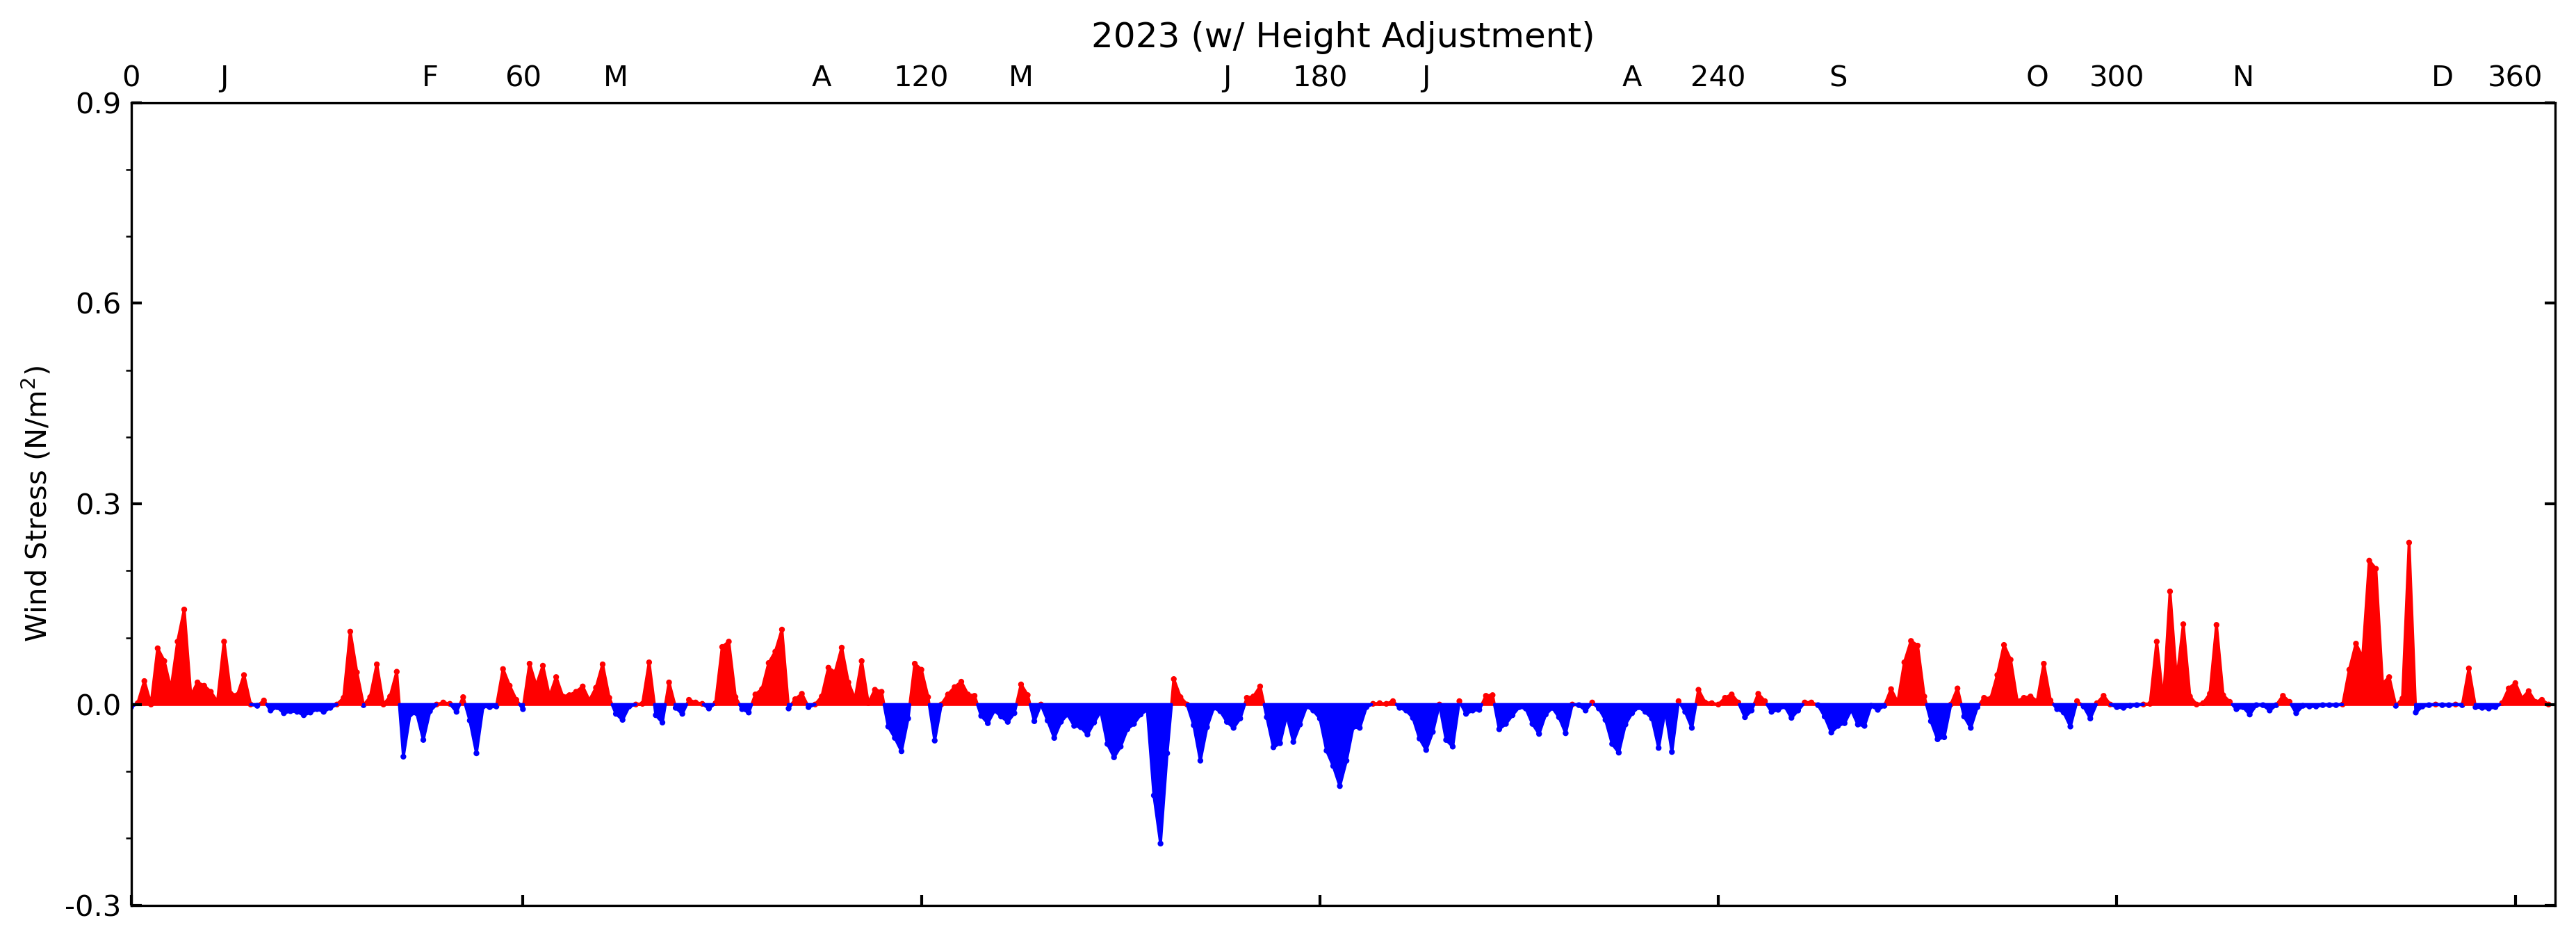

In [20]:
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax.scatter(ds.index, stress_w_height, c=colors, s=1)

# Fill the area under the curve
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax.set_xticklabels('')
ax.set_xticks((datetime(2023,1,15), datetime(2023,2,15), datetime(2023,3,15), datetime(2023,4,15), datetime(2023,5,15), datetime(2023,6,15), datetime(2023,7,15), 
            datetime(2023,8,15), datetime(2023,9,15), datetime(2023,10,15), datetime(2023,11,15), datetime(2023,12,15)), minor=True)
ax.set_xticks((datetime(2023,1,1), datetime(2023,3,1), datetime(2023,4,30), datetime(2023,6,29), datetime(2023,8,28), datetime(2023,10,27), datetime(2023,12,26)))
ax.set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'), minor=True)
ax.set_xticklabels(('0', '60', '120', '180', '240', '300', '360'))
ax.set_xlim(datetime(2023,1,1), datetime(2024,1,1))
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(width=1, top=False, right=True, bottom=True, direction='in', which='major')

# Remove minor tick labels
ax.tick_params(axis='x', which='minor', length=0)

# Set x-axis label position to top
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Turn off major ticks at the top
ax.tick_params(axis='x', which='major', top=False)

# Turn on major ticks at the bottom
ax.tick_params(axis='x', which='major', bottom=True, direction='in')

ax.set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_yticks((-0.2, -0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8), minor=True)
ax.set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_ylim(-0.3, 0.9)

ax.set_ylabel(r'Wind Stress (N/m$^2$)')
ax.set_title('2023 (w/ Height Adjustment)')

In [21]:
# Correctly filter the time range
start_date = np.datetime64('2023-04-24T00:00:00.000000000')
end_date = np.datetime64('2023-09-22T00:00:00.000000000')

mask = np.logical_and(ds.index >= start_date, ds.index <= end_date)

new_time2 = ds.index[mask]
new_vcomp_N2 = stress_w_height[mask]
cumulative_sum_adj = (np.cumsum(new_vcomp_N2))
# cumulative_sum2 = (np.cumsum(new_vcomp_N2))


# cumulative_sum2 = pd.DataFrame(cumulative_sum2)
# cumulative_sum2 = cumulative_sum2.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()

cumsum_min_adj = cumulative_sum_adj.min()
cumsum_min_adj = round(cumsum_min_adj, 3)
cumsum_min_adj = str(cumsum_min_adj)

print(cumsum_min_adj)

-3.086


Text(0.5, 1.0, '2023 (w/ Height Adjustment)')

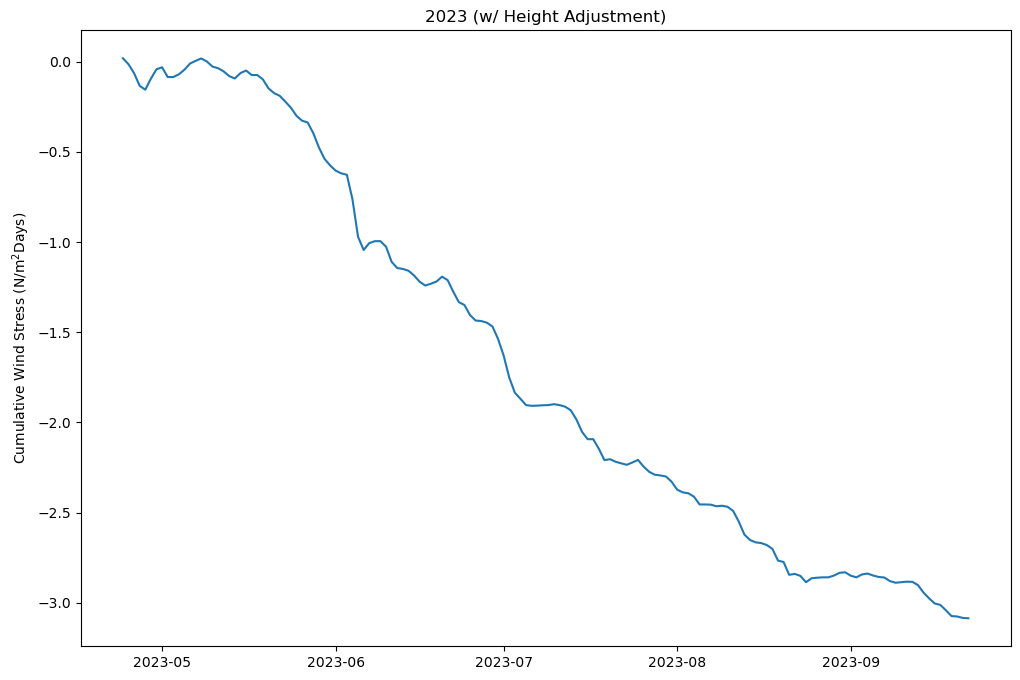

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(new_time2, cumulative_sum_adj)

ax.set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
ax.set_title('2023 (w/ Height Adjustment)')

Text(2023-09-27 00:00:00, -3.3359999999999994, '-3.642 N/$m^2$Days (Steve)')

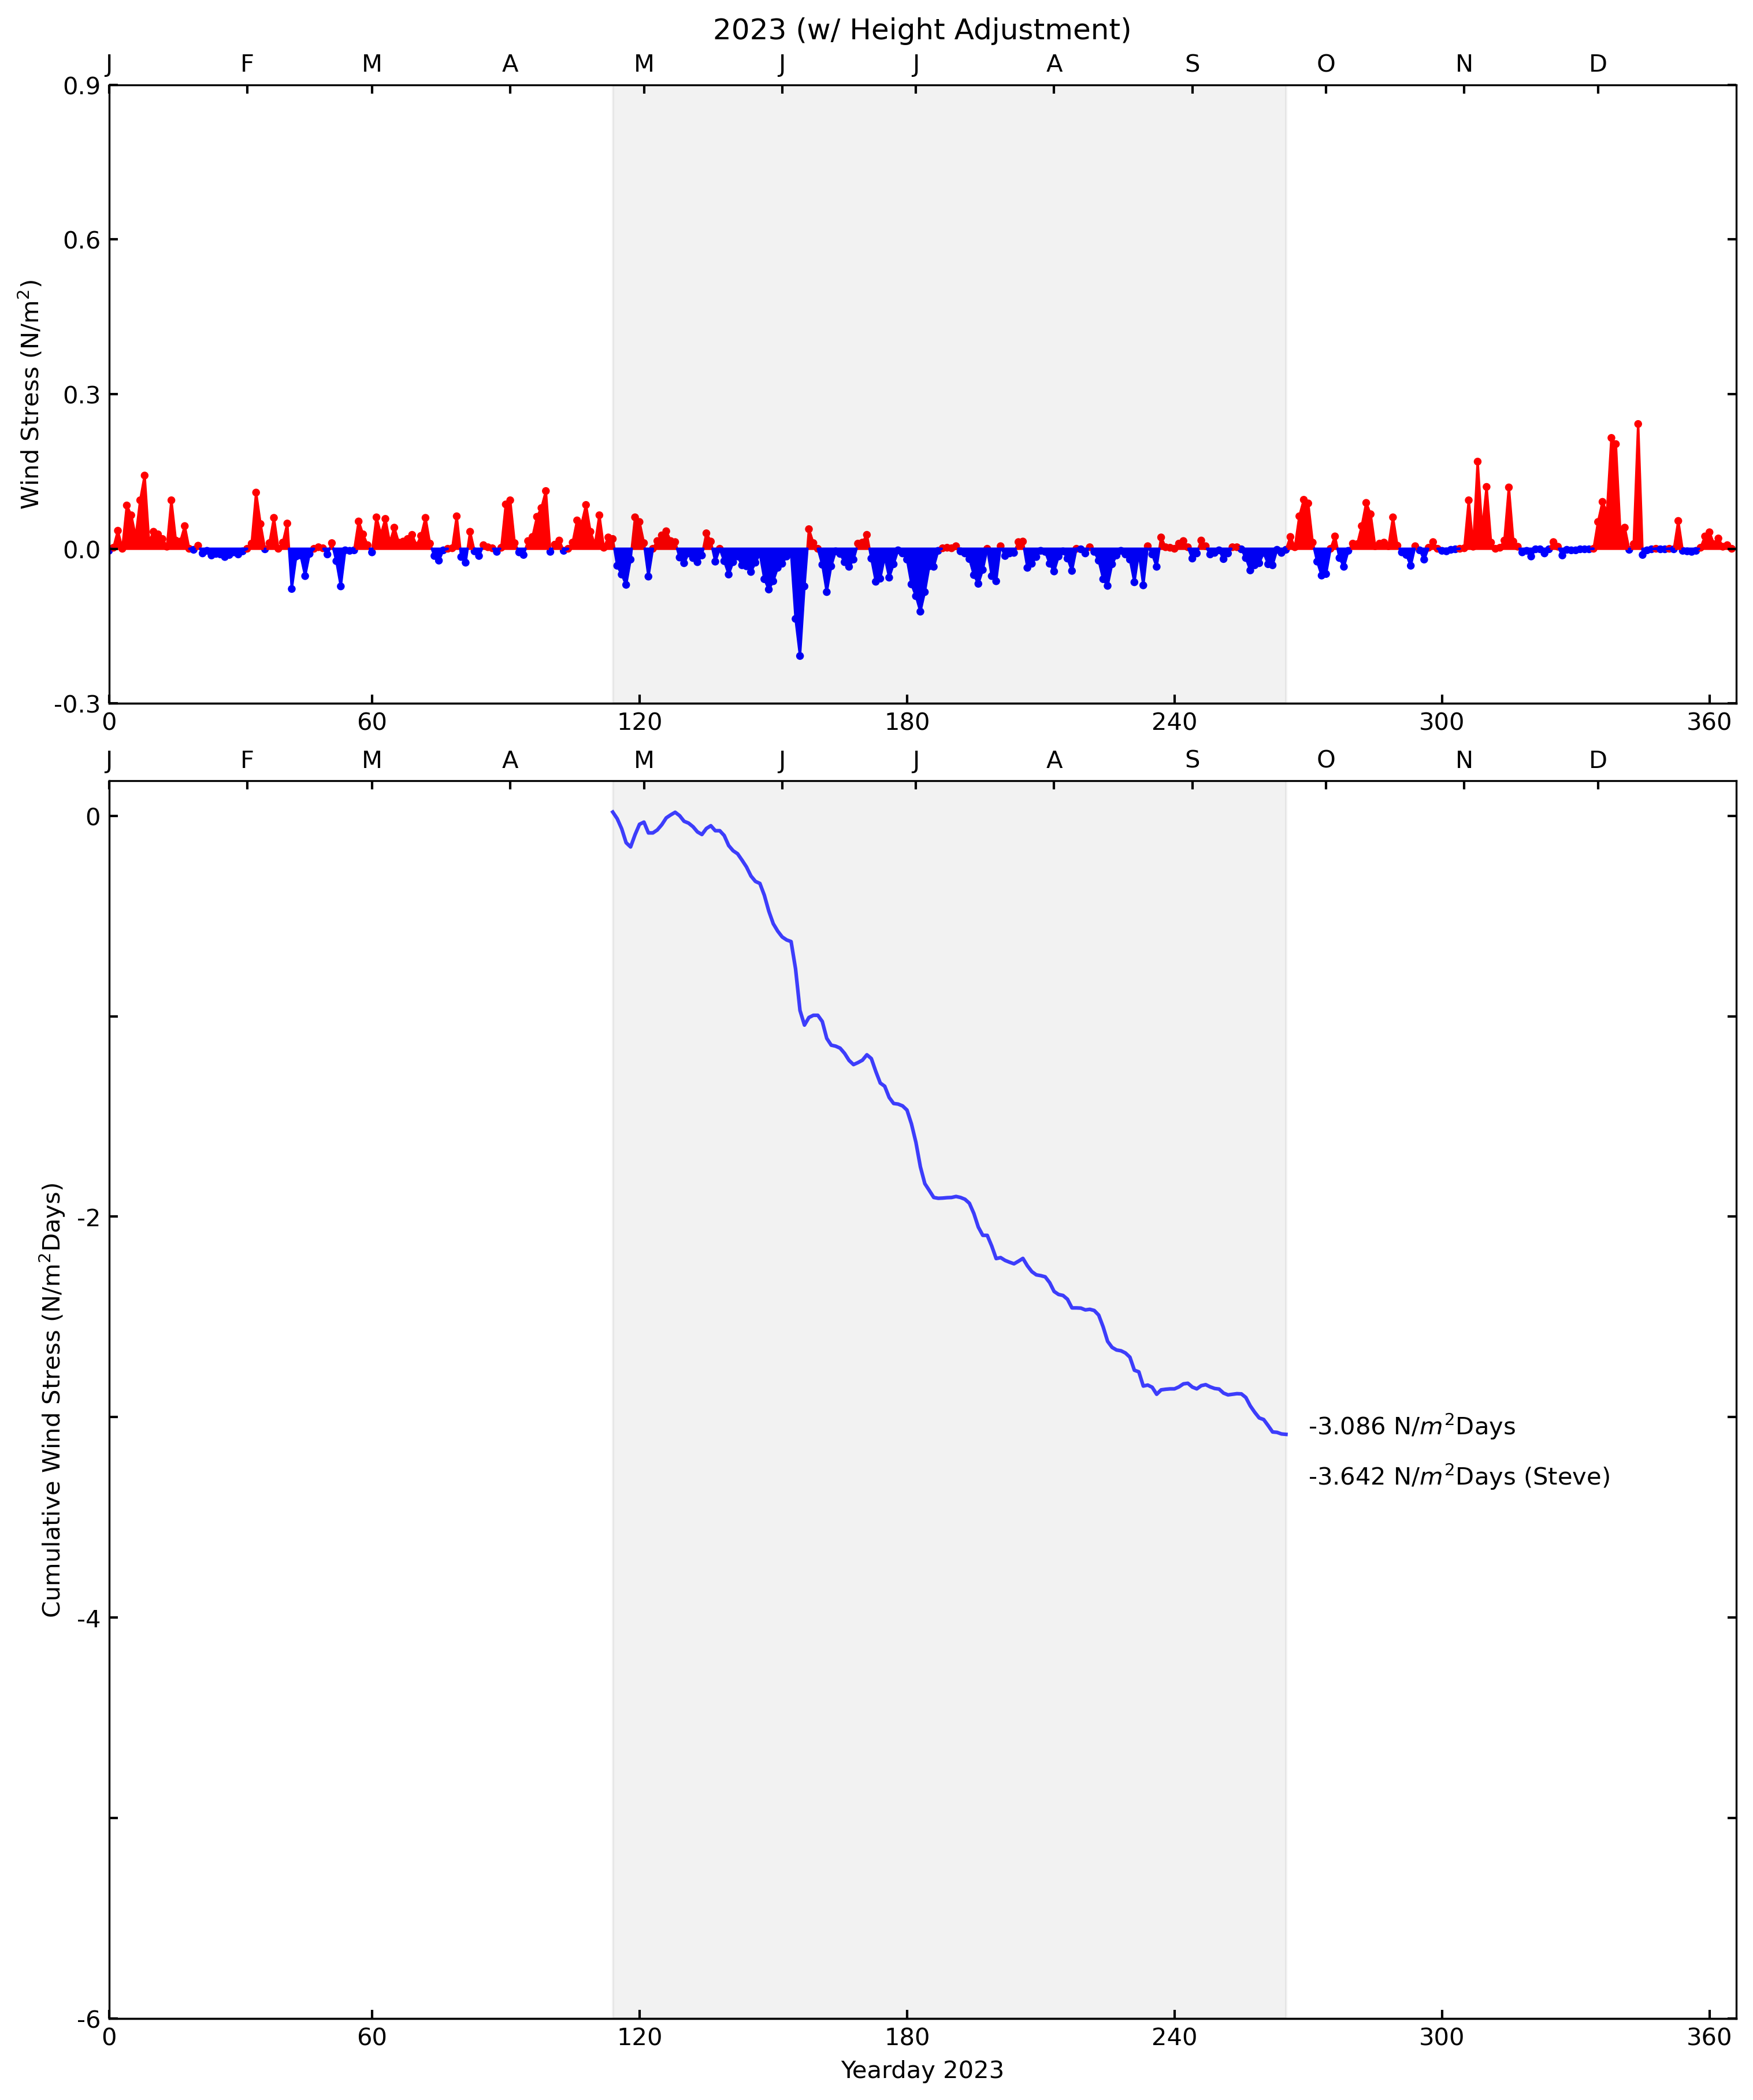

In [23]:
fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                               ['lower', 'lower', 'lower'],
                                     ['lower', 'lower', 'lower']],
                              figsize=(10, 12), layout="constrained", dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax['upper'].scatter(ds.index, stress_w_height, c=colors, s=5)

# Fill the area under the curve
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax['upper'].set_xticklabels('')
ax['upper'].set_xticks((datetime(2023,1,1), datetime(2023,2,1), datetime(2023,3,1), datetime(2023,4,1), datetime(2023,5,1), datetime(2023,6,1), datetime(2023,7,1), 
            datetime(2023,8,1), datetime(2023,9,1), datetime(2023,10,1), datetime(2023,11,1), datetime(2023,12,1)))
ax['upper'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['upper'].set_xlim(datetime(2023,1,1), datetime(2024,1,1))
ax['upper'].xaxis.set_label_position('top') 
ax['upper'].xaxis.tick_top()
ax['upper'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax['upper'].secondary_xaxis(location=0)
sec.set_xticks([datetime(2023,1,1), datetime(2023,3,1), datetime(2023,4,30), datetime(2023,6,29), datetime(2023,8,28), datetime(2023,10,27), datetime(2023,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_ylim(-0.3, 0.9)

ax['upper'].set_ylabel(r'Wind Stress (N/m$^2$)')
ax['upper'].set_title('2023 (w/ Height Adjustment)')

ax['lower'].plot(new_time2, cumulative_sum_adj, c='b', alpha=0.75)
ax['lower'].set_xticklabels('')
ax['lower'].set_xticks((datetime(2023,1,1), datetime(2023,2,1), datetime(2023,3,1), datetime(2023,4,1), datetime(2023,5,1), datetime(2023,6,1), datetime(2023,7,1), 
            datetime(2023,8,1), datetime(2023,9,1), datetime(2023,10,1), datetime(2023,11,1), datetime(2023,12,1)))
ax['lower'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['lower'].set_xlim(datetime(2023,1,1), datetime(2024,1,1))
ax['lower'].xaxis.set_label_position('top') 
ax['lower'].xaxis.tick_top()
ax['lower'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')
ax['lower'].set_yticks((0, -1, -2, -3, -4, -5, -6))
ax['lower'].set_yticklabels(('0', '', '-2', '', '-4', '', '-6'))

sec2 = ax['lower'].secondary_xaxis(location=0)
sec2.set_xticks([datetime(2023,1,1), datetime(2023,3,1), datetime(2023,4,30), datetime(2023,6,29), datetime(2023,8,28), datetime(2023,10,27), datetime(2023,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec2.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].axvspan(xmin=datetime(2023,4,24), xmax=datetime(2023,9,22), color='k', alpha=0.05)
ax['lower'].axvspan(xmin=datetime(2023,4,24), xmax=datetime(2023,9,22), color='k', alpha=0.05)

ax['lower'].set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
sec2.set_xlabel(r'Yearday 2023')

ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_adj.min(), cumsum_min_adj + ' ' + r'N/$m^2$Days')
ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_adj.min() - 0.25, '-3.642' + ' ' + r"N/$m^2$Days (Steve)")

## Plots (raw)

Text(0.5, 1.0, '2023 (raw)')

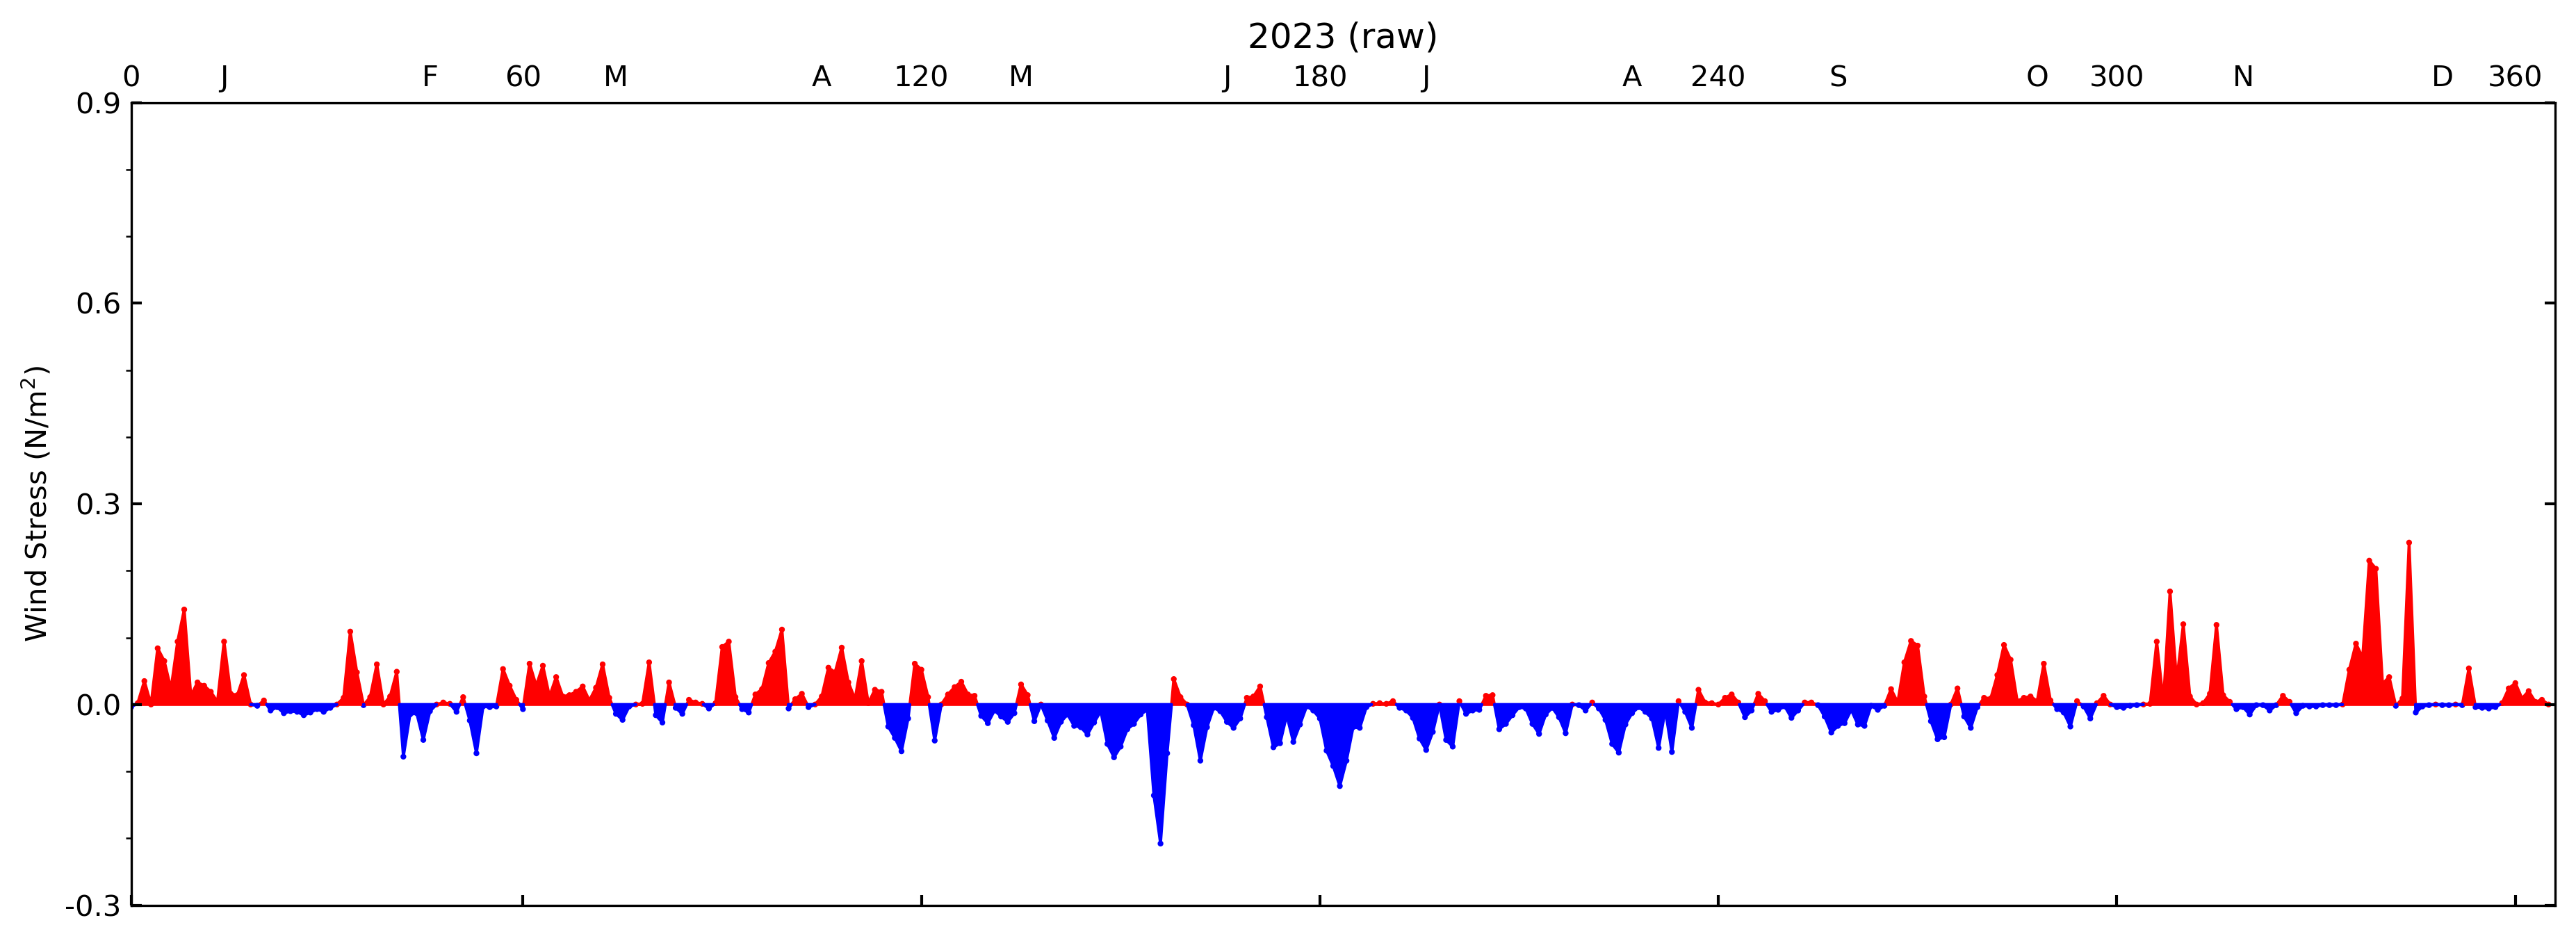

In [24]:
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax.scatter(ds.index, stress_w_height, c=colors, s=1)

# Fill the area under the curve
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax.set_xticklabels('')
ax.set_xticks((datetime(2023,1,15), datetime(2023,2,15), datetime(2023,3,15), datetime(2023,4,15), datetime(2023,5,15), datetime(2023,6,15), datetime(2023,7,15), 
            datetime(2023,8,15), datetime(2023,9,15), datetime(2023,10,15), datetime(2023,11,15), datetime(2023,12,15)), minor=True)
ax.set_xticks((datetime(2023,1,1), datetime(2023,3,1), datetime(2023,4,30), datetime(2023,6,29), datetime(2023,8,28), datetime(2023,10,27), datetime(2023,12,26)))
ax.set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'), minor=True)
ax.set_xticklabels(('0', '60', '120', '180', '240', '300', '360'))
ax.set_xlim(datetime(2023,1,1), datetime(2024,1,1))
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(width=1, top=False, right=True, bottom=True, direction='in', which='major')

# Remove minor tick labels
ax.tick_params(axis='x', which='minor', length=0)

# Set x-axis label position to top
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Turn off major ticks at the top
ax.tick_params(axis='x', which='major', top=False)

# Turn on major ticks at the bottom
ax.tick_params(axis='x', which='major', bottom=True, direction='in')

ax.set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_yticks((-0.2, -0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8), minor=True)
ax.set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_ylim(-0.3, 0.9)

ax.set_ylabel(r'Wind Stress (N/m$^2$)')
ax.set_title('2023 (raw)')

In [25]:
# Correctly filter the time range
start_date = np.datetime64('2023-04-24T00:00:00.000000000')
end_date = np.datetime64('2023-09-22T00:00:00.000000000')

mask = np.logical_and(ds.index >= start_date, ds.index <= end_date)

new_time2 = ds.index[mask]
new_vcomp_N2 = stress_raw[mask]
cumulative_sum_raw = (np.cumsum(new_vcomp_N2))
# cumulative_sum2 = (np.cumsum(new_vcomp_N2))


# cumulative_sum2 = pd.DataFrame(cumulative_sum2)
# cumulative_sum2 = cumulative_sum2.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()

cumsum_min_raw = cumulative_sum_raw.min()
cumsum_min_raw = round(cumsum_min_raw, 3)
cumsum_min_raw = str(cumsum_min_raw)

print(cumsum_min_raw)

-3.411


Text(0.5, 1.0, '2023 (raw)')

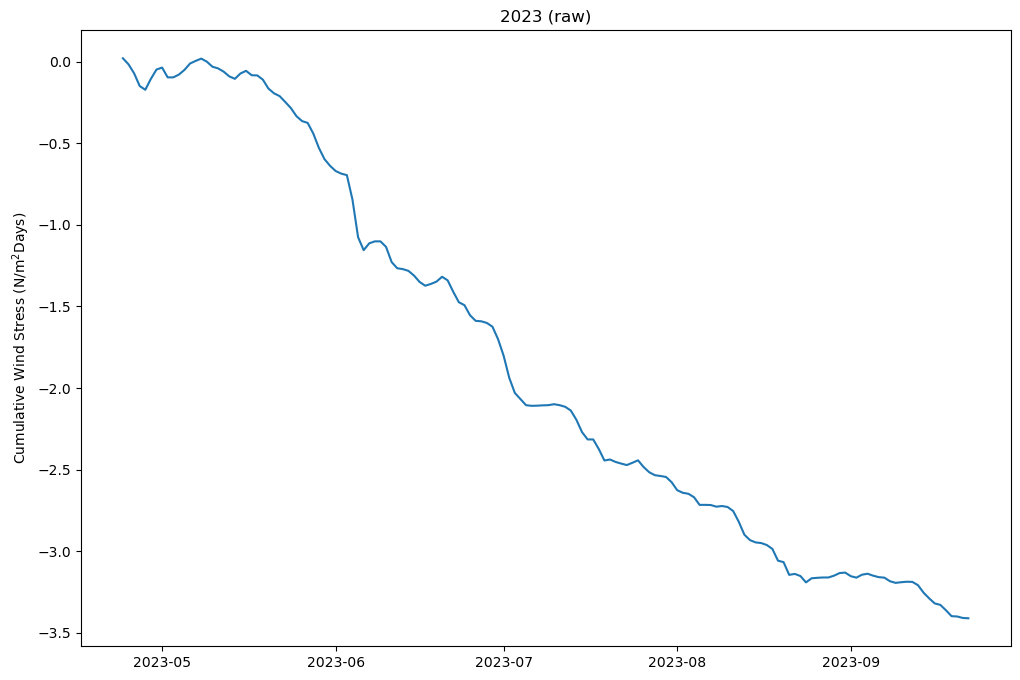

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(new_time2, cumulative_sum_raw)

ax.set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
ax.set_title('2023 (raw)')

Text(2023-09-27 00:00:00, -3.660999999999998, '-3.642 N/$m^2$Days (Steve)')

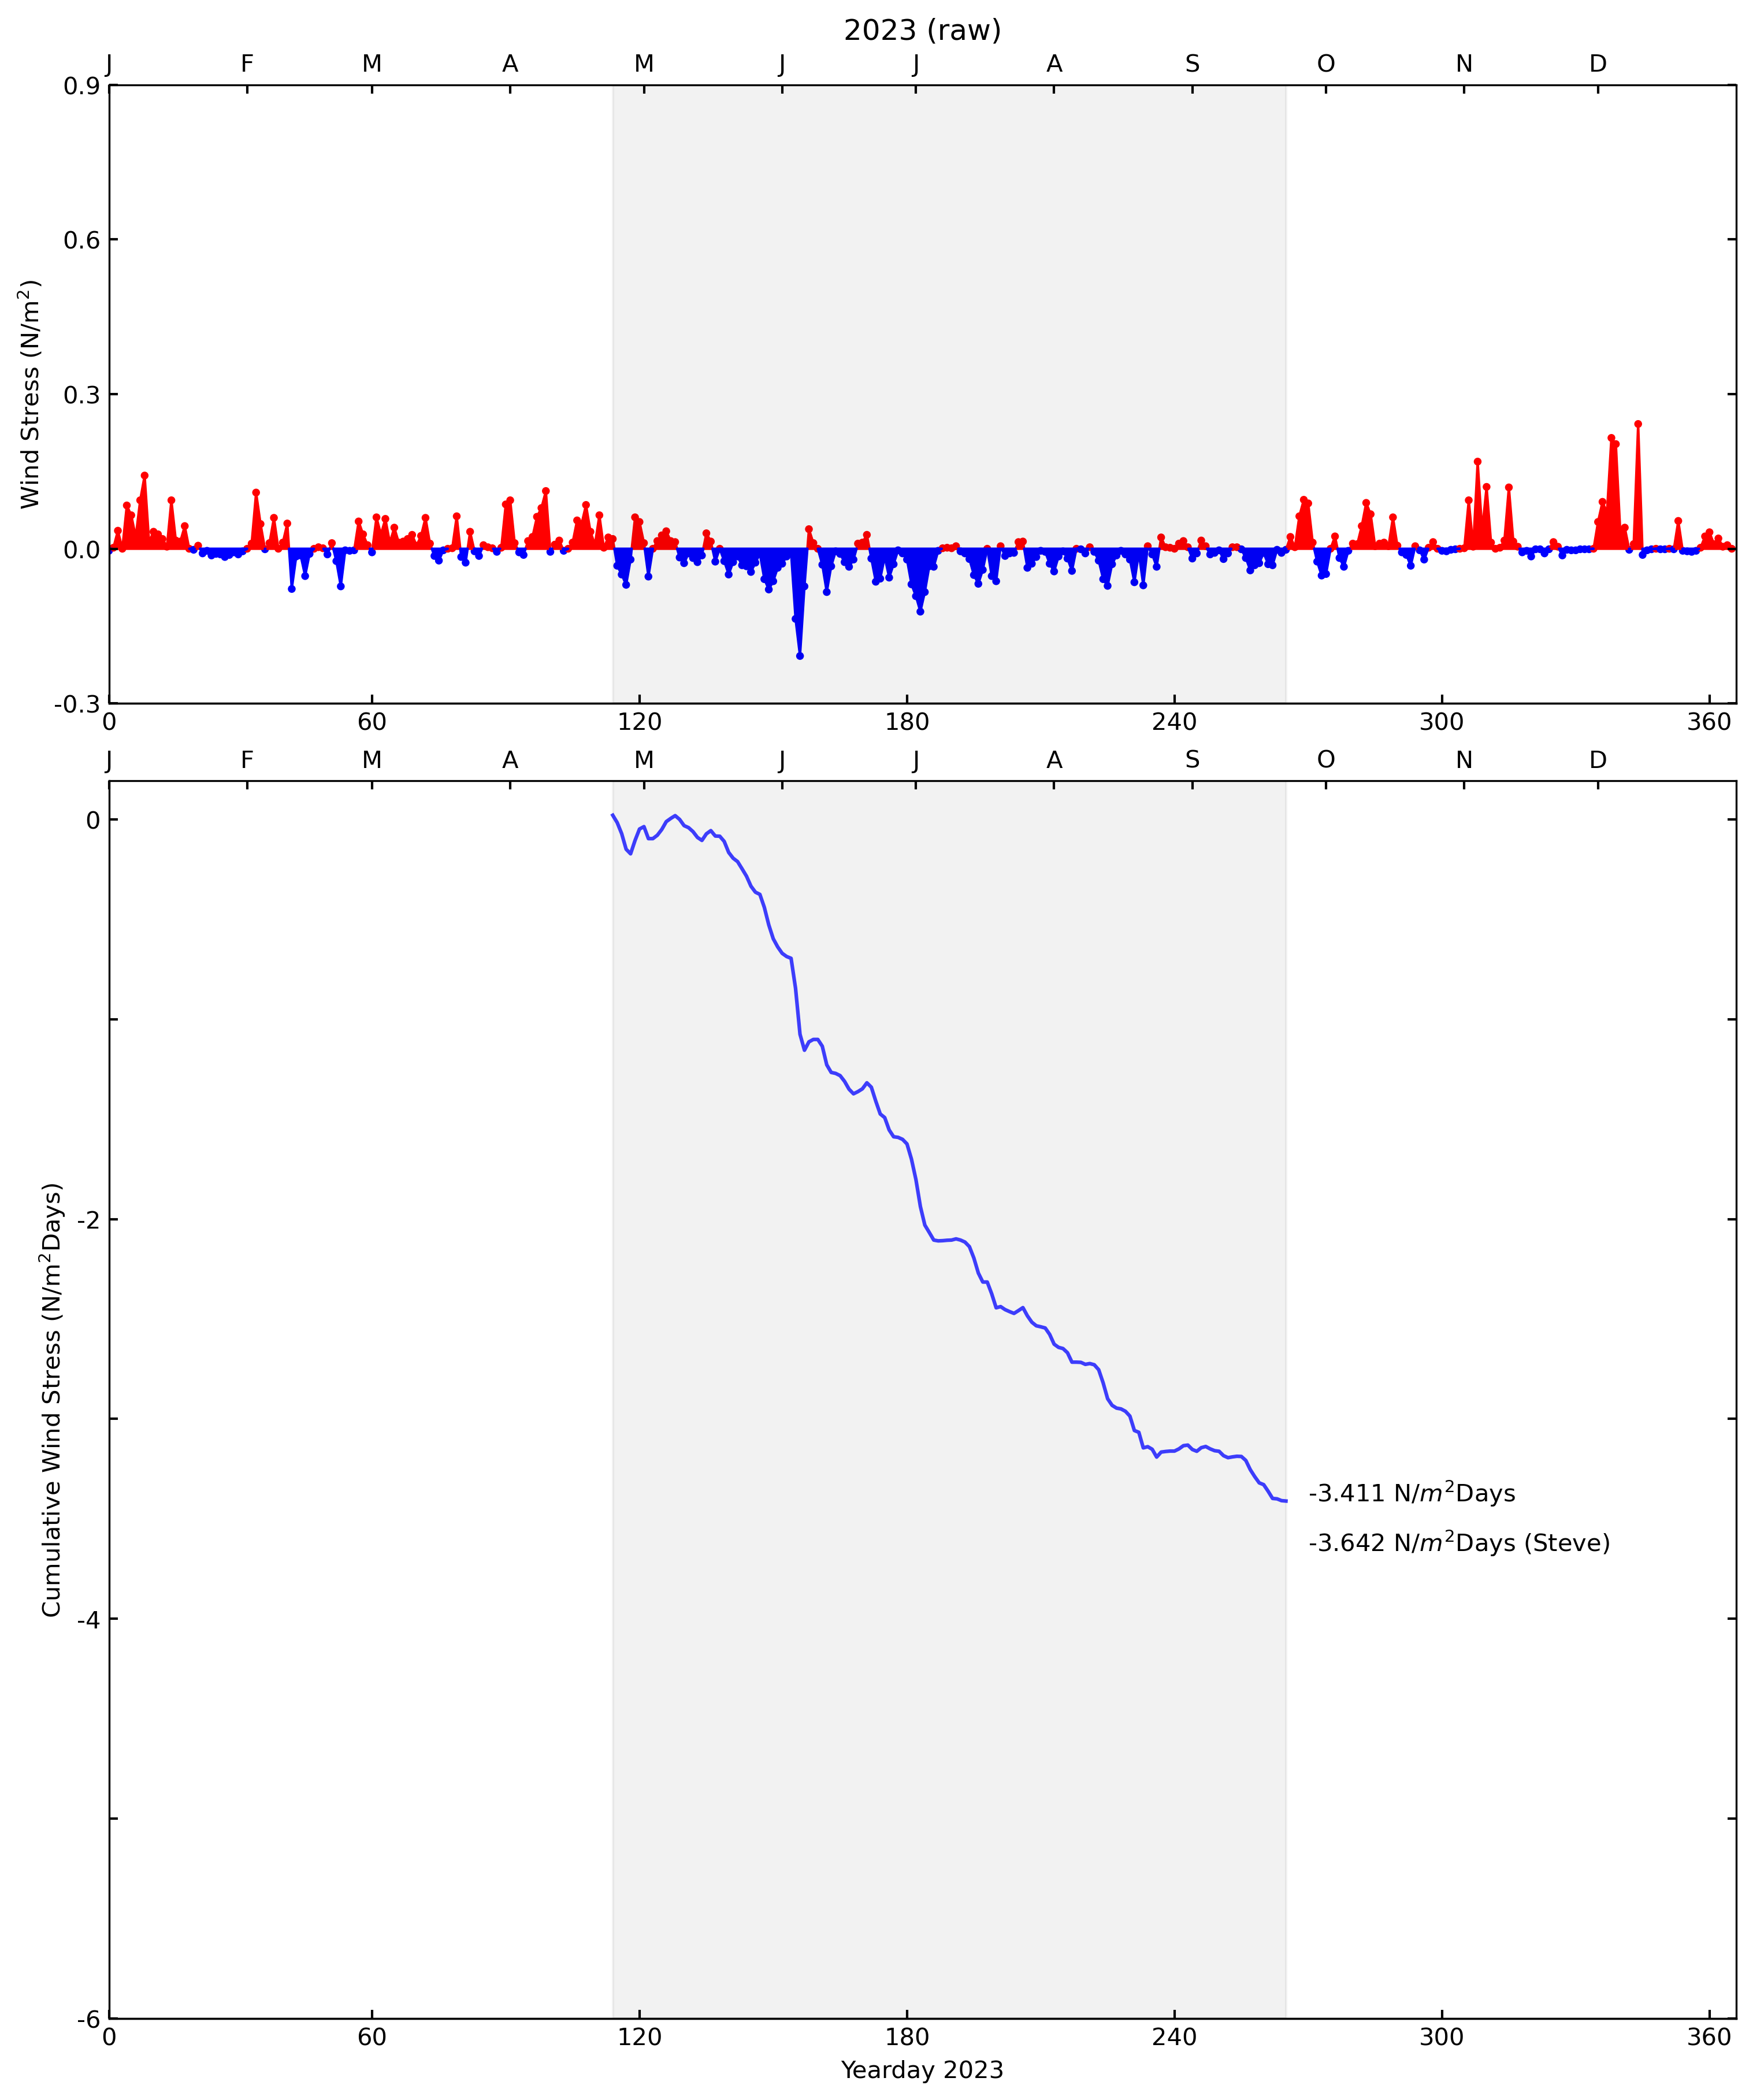

In [27]:
fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                               ['lower', 'lower', 'lower'],
                                     ['lower', 'lower', 'lower']],
                              figsize=(10, 12), layout="constrained", dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax['upper'].scatter(ds.index, stress_w_height, c=colors, s=5)

# Fill the area under the curve
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax['upper'].set_xticklabels('')
ax['upper'].set_xticks((datetime(2023,1,1), datetime(2023,2,1), datetime(2023,3,1), datetime(2023,4,1), datetime(2023,5,1), datetime(2023,6,1), datetime(2023,7,1), 
            datetime(2023,8,1), datetime(2023,9,1), datetime(2023,10,1), datetime(2023,11,1), datetime(2023,12,1)))
ax['upper'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['upper'].set_xlim(datetime(2023,1,1), datetime(2024,1,1))
ax['upper'].xaxis.set_label_position('top') 
ax['upper'].xaxis.tick_top()
ax['upper'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax['upper'].secondary_xaxis(location=0)
sec.set_xticks([datetime(2023,1,1), datetime(2023,3,1), datetime(2023,4,30), datetime(2023,6,29), datetime(2023,8,28), datetime(2023,10,27), datetime(2023,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_ylim(-0.3, 0.9)

ax['upper'].set_ylabel(r'Wind Stress (N/m$^2$)')
ax['upper'].set_title('2023 (raw)')

ax['lower'].plot(new_time2, cumulative_sum_raw, c='b', alpha=0.75)
ax['lower'].set_xticklabels('')
ax['lower'].set_xticks((datetime(2023,1,1), datetime(2023,2,1), datetime(2023,3,1), datetime(2023,4,1), datetime(2023,5,1), datetime(2023,6,1), datetime(2023,7,1), 
            datetime(2023,8,1), datetime(2023,9,1), datetime(2023,10,1), datetime(2023,11,1), datetime(2023,12,1)))
ax['lower'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['lower'].set_xlim(datetime(2023,1,1), datetime(2024,1,1))
ax['lower'].xaxis.set_label_position('top') 
ax['lower'].xaxis.tick_top()
ax['lower'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')
ax['lower'].set_yticks((0, -1, -2, -3, -4, -5, -6))
ax['lower'].set_yticklabels(('0', '', '-2', '', '-4', '', '-6'))

sec2 = ax['lower'].secondary_xaxis(location=0)
sec2.set_xticks([datetime(2023,1,1), datetime(2023,3,1), datetime(2023,4,30), datetime(2023,6,29), datetime(2023,8,28), datetime(2023,10,27), datetime(2023,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec2.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].axvspan(xmin=datetime(2023,4,24), xmax=datetime(2023,9,22), color='k', alpha=0.05)
ax['lower'].axvspan(xmin=datetime(2023,4,24), xmax=datetime(2023,9,22), color='k', alpha=0.05)

ax['lower'].set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
sec2.set_xlabel(r'Yearday 2023')

ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_raw.min(), cumsum_min_raw + ' ' + r'N/$m^2$Days')
ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_raw.min() - 0.25, '-3.642' + ' ' + r"N/$m^2$Days (Steve)")

# 2024 Data

## Open Datasets

In [28]:
ds1 = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2024.txt/nwpo3h2024.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
ds1['time'] = pd.to_datetime(ds1['#yr_mo_dy_hr_mn'], format='%Y %m %d %H %M')
ds1.replace('MM', np.nan, inplace=True)
# ds1

C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\985991872.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  ds1 = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2024.txt/nwpo3h2024.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\985991872.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds1 = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2024.txt/nwpo3h2024.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])


In [29]:
ds2 = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2024.txt/09_2024.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
ds2['time'] = pd.to_datetime(ds2['#yr_mo_dy_hr_mn'], format='%Y %m %d %H %M')
ds2.replace('MM', np.nan, inplace=True)
ds2 = ds2.sort_values(by=['time'], ascending=True)
ds2 = ds2.reset_index(drop=True)
ds2 = ds2.drop(['hPa.1'], axis=1)
# ds2

C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\955811504.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  ds2 = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2024.txt/09_2024.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\955811504.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds2 = pd.read_csv('C:/Users/marqjace/cui/nwpo3h2024.txt/09_2024.txt', sep='\s+', header=1, parse_dates=[['#yr', 'mo', 'dy', 'hr', 'mn']])
C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\955811504.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obje

In [30]:
frames = [ds1, ds2]
ds = pd.concat(frames)
ds = ds.sort_values(by=['time'])
ds = ds.reset_index(drop=True)
ds = ds.set_index(['time'])
ds = ds.drop(['sec', 'sec.1', 'deg', 'hPa', 'degC.1', 'degC.2', 'nmi', 'ft', 'degT.1', 'm', 'm/s.1'], axis=1)


#specify path for export
path = r'C:/Users/marqjace/cui/nwpo3h2024.txt/2024_tmp.txt'

#export DataFrame to text file (keep header row and index column)
with open(path, 'w') as f:
    ds_string = ds.to_string()
    f.write(ds_string)

ds

,#yr_mo_dy_hr_mn,degT,m/s,degC
time,,,,
2024-01-01 00:00:00,2024 01 01 00 00,77,1.8,10.7
2024-01-01 06:00:00,2024 01 01 06 00,82,3.5,6.0
2024-01-01 07:00:00,2024 01 01 07 00,82,3.6,5.6
2024-01-01 08:00:00,2024 01 01 08 00,77,3.3,5.4
2024-01-01 09:00:00,2024 01 01 09 00,79,3.6,5.1
...,...,...,...,...
2024-10-07 13:00:00,2024 10 07 13 00,90,2.1,13.9
2024-10-07 14:00:00,2024 10 07 14 00,90,2.6,13.9
2024-10-07 15:00:00,2024 10 07 15 00,90,4.6,14.1


## Create Variables

In [31]:
wdir = ds['degT'].values
wspeed = ds['m/s'].values
# time = ds['time'].values
temp = ds['degC'].values

# Generate a date range for 364 days starting from January 1, 2024
start_date = '2024-01-01'
num_days = 364

# Use pandas to create a date range
date_range = pd.date_range(start=start_date, periods=num_days)

# Convert the date range to a NumPy array
dates_array = np.array(date_range)

# print(dates_array)

# ds = ds.resample('D').mean(numeric_only=True)
ds

,#yr_mo_dy_hr_mn,degT,m/s,degC
time,,,,
2024-01-01 00:00:00,2024 01 01 00 00,77,1.8,10.7
2024-01-01 06:00:00,2024 01 01 06 00,82,3.5,6.0
2024-01-01 07:00:00,2024 01 01 07 00,82,3.6,5.6
2024-01-01 08:00:00,2024 01 01 08 00,77,3.3,5.4
2024-01-01 09:00:00,2024 01 01 09 00,79,3.6,5.1
...,...,...,...,...
2024-10-07 13:00:00,2024 10 07 13 00,90,2.1,13.9
2024-10-07 14:00:00,2024 10 07 14 00,90,2.6,13.9
2024-10-07 15:00:00,2024 10 07 15 00,90,4.6,14.1


## Calculate U,V Wind Components

In [32]:
ucomp = []
vcomp = []

for dir, speed in zip(wdir, wspeed):
    u, v = metpy.calc.wind_components(float(speed) * units('m/s'), float(dir) * units.deg)
    ucomp.append(u.magnitude)
    vcomp.append(v.magnitude)

# Convert to DataFrame
ucomp = pd.DataFrame(ucomp, columns=['ucomp'], index=ds.index)
vcomp = pd.DataFrame(vcomp, columns=['vcomp'], index=ds.index)

ds['ucomp'] = ucomp
ds['vcomp'] = vcomp

# ds = ds.resample('D').mean(numeric_only=True)

vcomp_new = ds['vcomp']

vcomp_new

time
2024-01-01 00:00:00   -4.049119e-01
2024-01-01 06:00:00   -4.871059e-01
2024-01-01 07:00:00   -5.010232e-01
2024-01-01 08:00:00   -7.423385e-01
2024-01-01 09:00:00   -6.869124e-01
                           ...     
2024-10-07 13:00:00   -1.285879e-16
2024-10-07 14:00:00   -1.592041e-16
2024-10-07 15:00:00   -2.816688e-16
2024-10-07 16:00:00   -1.402283e+00
2024-10-07 17:00:00   -6.251334e-01
Name: vcomp, Length: 6732, dtype: float64

## Wind Stress Calculation Function

In [33]:
kappa = 0.4  # von Karman's constant
Charnock_alpha = 0.011  # Charnock constant for open-ocean
R_roughness = 0.11  # Limiting roughness Reynolds for aerodynamically smooth flow
g = 9.8  # Acceleration due to gravity [m/s^2]

def cdn(sp, z, drag='largepond', Ta=temp):
    """Computes neutral drag coefficient and wind speed at 10 m."""
    sp, z, Ta = np.asarray(sp), np.asarray(z), np.asarray(Ta)
    tol = 0.00001

    if drag == 'largepond':
        a = np.log(z / 10.) / kappa
        u10o = np.zeros(sp.shape)
        cd = 1.15e-3 * np.ones(sp.shape)
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol

        while np.any(ii):
            u10o = u10
            cd = (4.9e-4 + 6.5e-5 * u10o)
            cd[u10o < 10.15385] = 1.15e-3
            u10 = sp / (1 + a * np.sqrt(cd))
            ii = np.abs(u10 - u10o) > tol

    elif drag == 'smith':
        visc = visc_air(Ta)
        ustaro = np.zeros(sp.shape)
        ustarn = 0.036 * sp
        ii = np.abs(ustarn - ustaro) > tol
        while np.any(ii):
            ustaro = ustarn
            z0 = Charnock_alpha * ustaro ** 2 / g + R_roughness * visc / ustaro
            ustarn = sp * (kappa / np.log(z / z0))
            ii = np.abs(ustarn - ustaro) > tol

        sqrcd = kappa / np.log(10. / z0)
        cd = sqrcd ** 2
        u10 = ustarn / sqrcd

    elif drag == 'vera':
        A = 2.717e-3
        B = 0.142e-3
        C = 0.0764e-3
        a = np.log(z / 10.) / kappa
        u10o = np.zeros(sp.shape) + 0.1
        cd = A / u10o + B + C * u10o
        u10 = sp / (1 + a * np.sqrt(cd))
        ii = np.abs(u10 - u10o) > tol
        while np.any(ii):
            u10o = u10
            cd = A / u10o + B + C * u10o
            u10 = sp / (1 + a * np.sqrt(cd))
            ii = np.abs(u10 - u10o) > tol
    else:
        raise ValueError('Unknown method')

    return cd, u10

def stress(sp, z=10., drag='largepond', rho_air=1.22, Ta=temp):
    """Computes the neutral wind stress."""
    z, sp = np.asarray(z), np.asarray(sp)
    Ta, rho_air = np.asarray(Ta), np.asarray(rho_air)

    if drag == 'largepond':
        cd, sp = cdn(sp, z, 'largepond')
    elif drag == 'smith':
        cd, sp = cdn(sp, z, 'smith', Ta)
    elif drag == 'vera':
        cd, sp = cdn(sp, z, 'vera')
    else:
        raise ValueError('Unknown method')

    tau = rho_air * (cd * sp * np.abs(sp))

    return tau

## m/s to N/m^2

In [34]:
vcomp_N_adj = stress(vcomp_new, drag='largepond', z=18.5)
vcomp_N_raw = stress(vcomp_new, drag='largepond', z=10)

ds['stress_w_height'] = vcomp_N_adj
ds['stress_raw'] = vcomp_N_raw

ds = ds.resample('D').mean(numeric_only=True)

ds['stress_w_height'] = np.round(ds['stress_w_height'], 3)
ds['stress_raw'] = np.round(ds['stress_raw'], 3)

stress_w_height = ds['stress_w_height']
stress_raw = ds['stress_raw']

# vcomp_N = pd.DataFrame(vcomp_N, columns=['vcomp'])
# vcomp_N = vcomp_N.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()
# vcomp_N = np.array(vcomp_N, dtype='float32')

ds

,m/s,degC,ucomp,vcomp,stress_w_height,stress_raw
time,,,,,,
2024-01-01,4.142105,6.478947,-4.089427,-0.521859,-0.001,-0.001
2024-01-02,4.825000,7.729167,-4.752210,-0.234500,-0.000,-0.000
2024-01-03,4.783333,10.283333,0.956320,2.306869,0.009,0.010
2024-01-04,6.475000,9.495833,1.563141,3.418315,0.039,0.045
2024-01-05,4.150000,8.112500,0.249503,1.420258,0.014,0.016
...,...,...,...,...,...,...
2024-10-03,4.308333,10.325000,0.076900,-3.895170,-0.035,-0.039
2024-10-04,2.287500,10.300000,-0.149086,1.623245,0.010,0.011
2024-10-05,3.641667,11.358333,-1.958971,-1.809293,-0.010,-0.011


## Create txt file

In [35]:
file1 = open('C:/Users/marqjace/cui/nwpo3h2024.txt/simple.txt', 'w')
file1.write('# Spring transition day: 90' + '\n' + 'Fall transition day: 219' + '\n' + 'column 1:  yearday 2024 (UTC)' + '\n' + 'column 2:  northward windstress (Newtons/m2)' + '\n' + 'column 3:  cumulative-from-spring-transition northward windstress' + '\n' + '               [ending at fall transition]      (Newtons/m2*days)' + '\n')
# for x, value in zip(range(len(cumulative_sum2)), vcomp_N):
#     file1.write(str(x) + '   ' + str(value) + '   ' + str(cumulative_sum2[x]) + '\n')
# file1.close()

for x, value in zip(range(len(vcomp_N_adj)), range(len(cumulative_sum_adj))):
    file1.write(str(x + 90) + '   ' + str(vcomp_N_adj[x]) + '   ' + str(cumulative_sum_adj[value]) + '\n')
file1.close()

# open and read the file after the appending:
# f = open('C:/Users/marqjace/cui/nwpo3h2024.txt/simple.txt', "r")
# print(f.read())

C:\Users\marqjace\AppData\Local\Temp\ipykernel_24360\4293901240.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file1.write(str(x + 90) + '   ' + str(vcomp_N_adj[x]) + '   ' + str(cumulative_sum_adj[value]) + '\n')


In [36]:
file1 = open('C:/Users/marqjace/cui/nwpo3h2024.txt/simple2.txt', 'w')
file1.write('# Spring transition day: 90' + '\n' + '# Fall transition day: 219' + '\n' + '# column 1:  yearday 2024 (UTC)' + '\n' + '# column 2:  northward windstress (Newtons/m2)' + '\n' + '# column 3:  cumulative-from-spring-transition northward windstress' + '\n' + '#                [ending at fall transition]      (Newtons/m2*days)' + '\n')
# for x, value in zip(range(len(cumulative_sum2)), vcomp_N):
#     file1.write(str(x) + '   ' + str(value) + '   ' + str(cumulative_sum2[x]) + '\n')
# file1.close()

for x in range(len(vcomp_N_adj)):
    file1.write(str(x + 1) + '   ' + str(vcomp_N_adj[x]) + '\n')
file1.close()

# open and read the file after the appending:
# f = open('C:/Users/marqjace/cui/nwpo3h2024.txt/simple2.txt', "r")
# print(f.read())

## Plots (w/ Height Adjustment)

Text(0.5, 1.0, '2024 (w/ Height Adjustment)')

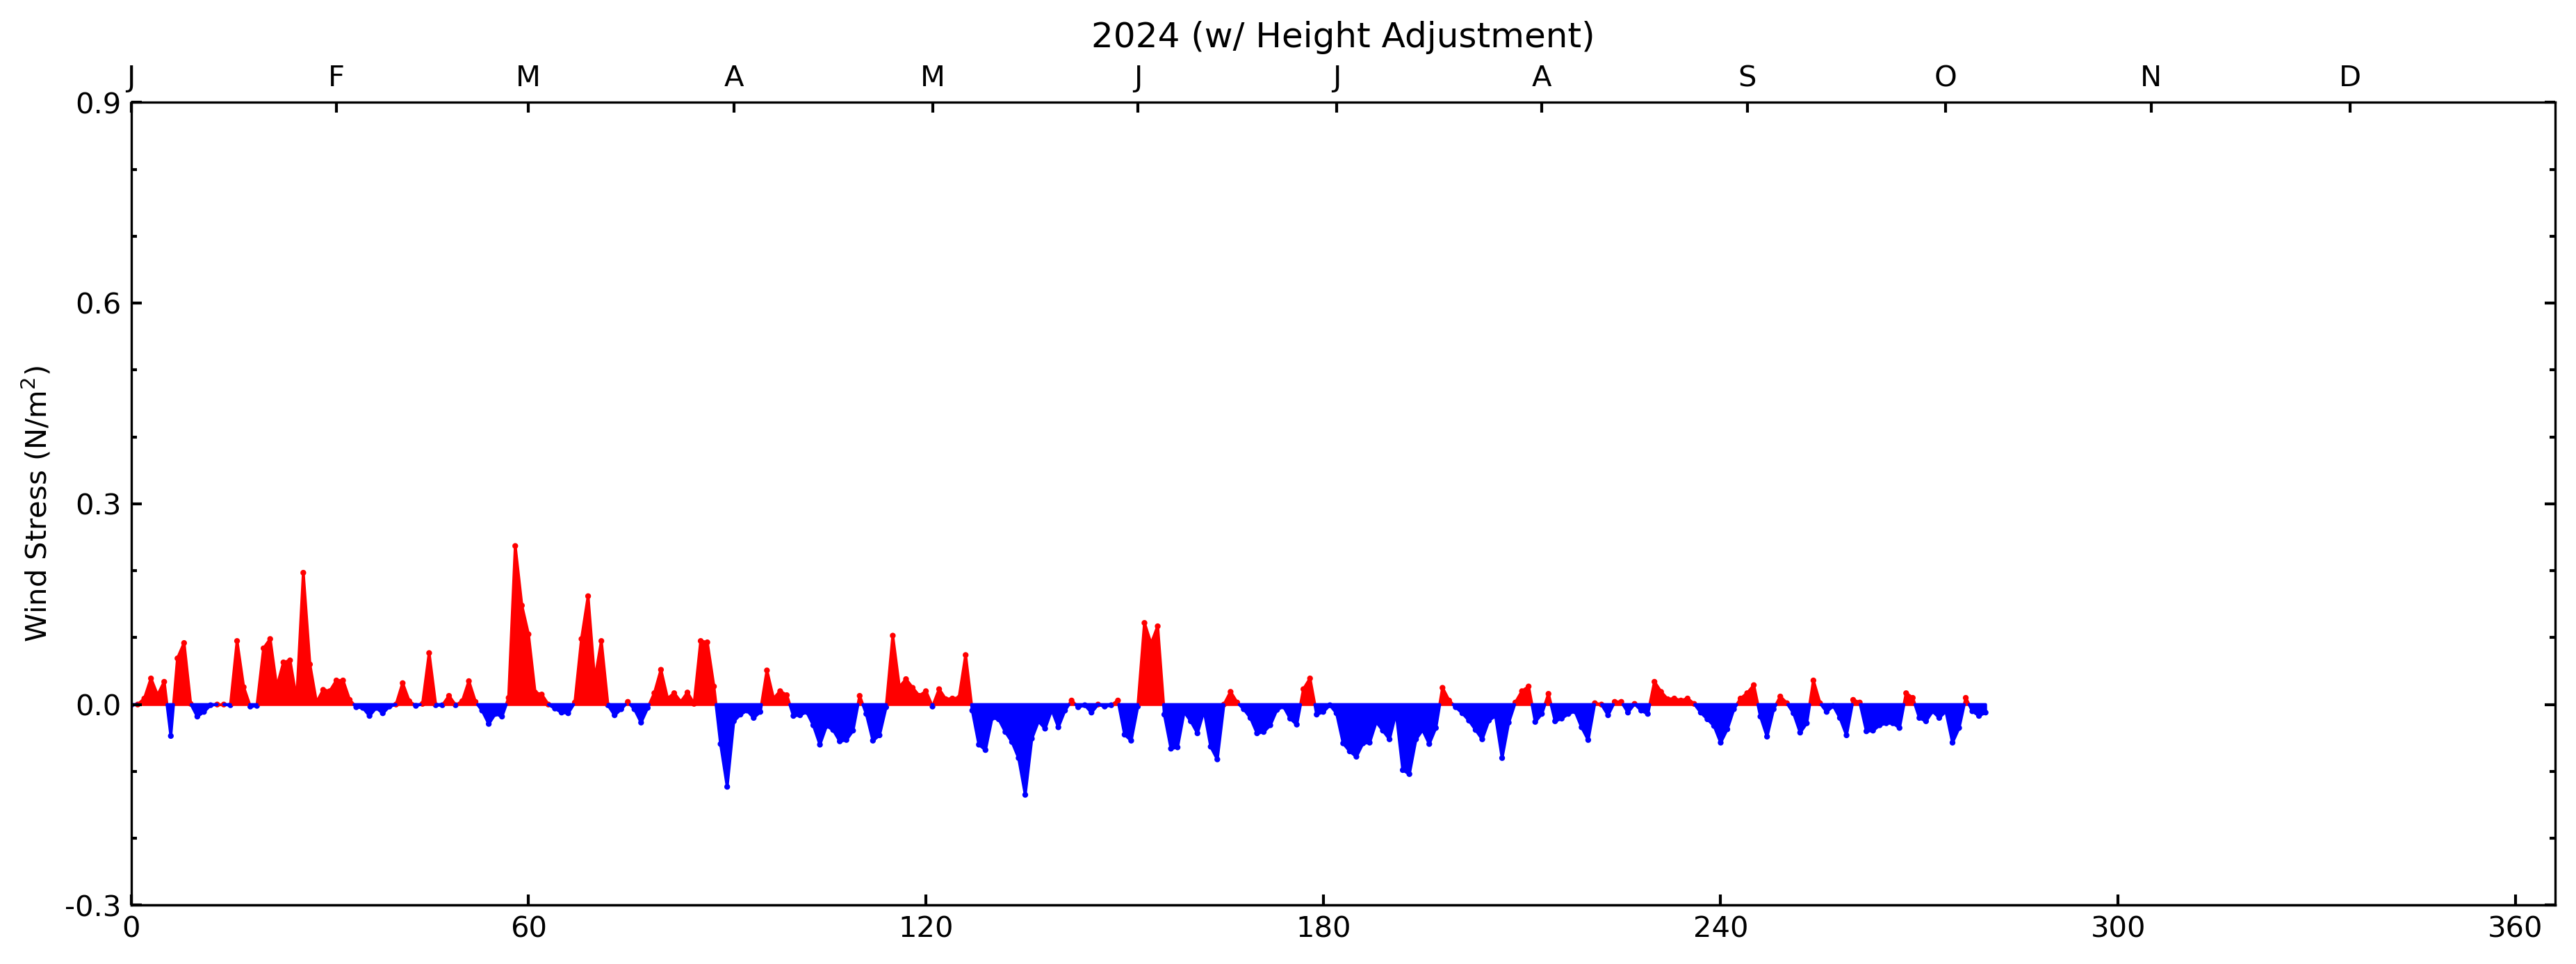

In [37]:
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax.scatter(ds.index, stress_w_height, c=colors, s=1)

# Fill the area under the curve
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax.fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax.set_xticklabels('')
ax.set_xticks((datetime(2024,1,1), datetime(2024,2,1), datetime(2024,3,1), datetime(2024,4,1), datetime(2024,5,1), datetime(2024,6,1), datetime(2024,7,1), 
            datetime(2024,8,1), datetime(2024,9,1), datetime(2024,10,1), datetime(2024,11,1), datetime(2024,12,1)))
ax.set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax.set_xlim(datetime(2024,1,1), datetime(2025,1,1))
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([datetime(2024,1,1), datetime(2024,3,1), datetime(2024,4,30), datetime(2024,6,29), datetime(2024,8,28), datetime(2024,10,27), datetime(2024,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax.set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_yticks((-0.2, -0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8), minor=True)
ax.set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_ylim(-0.3, 0.9)

ax.set_ylabel(r'Wind Stress (N/m$^2$)')
ax.set_title('2024 (w/ Height Adjustment)')

In [38]:
# Correctly filter the time range
start_date = np.datetime64('2024-03-30T00:00:00.000000000')
end_date = np.datetime64('2024-10-07T00:00:00.000000000')

mask = np.logical_and(ds.index >= start_date, ds.index <= end_date)

new_time2 = ds.index[mask]
new_vcomp_N2 = stress_w_height[mask]
cumulative_sum_adj = (np.cumsum(new_vcomp_N2))

# cumulative_sum2 = pd.DataFrame(cumulative_sum2)
# cumulative_sum2 = cumulative_sum2.rolling(window=1, center=True, win_type='boxcar', min_periods=1).mean()

cumsum_min_adj = cumulative_sum_adj.min()
cumsum_min_adj = round(cumsum_min_adj, 3)
cumsum_min_adj = str(cumsum_min_adj)

print(cumsum_min_adj)

-3.086


Text(0.5, 1.0, '2024')

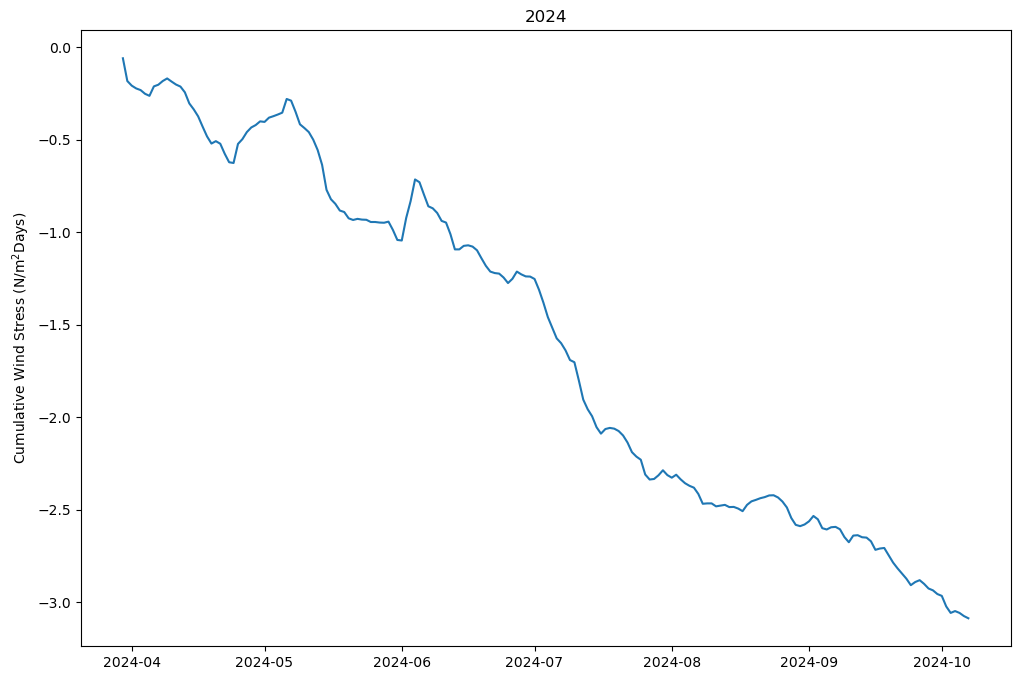

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(new_time2, cumulative_sum_adj)

ax.set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
ax.set_title('2024')

Text(2024-10-12 00:00:00, -3.086, '-3.086 N/$m^2$Days')

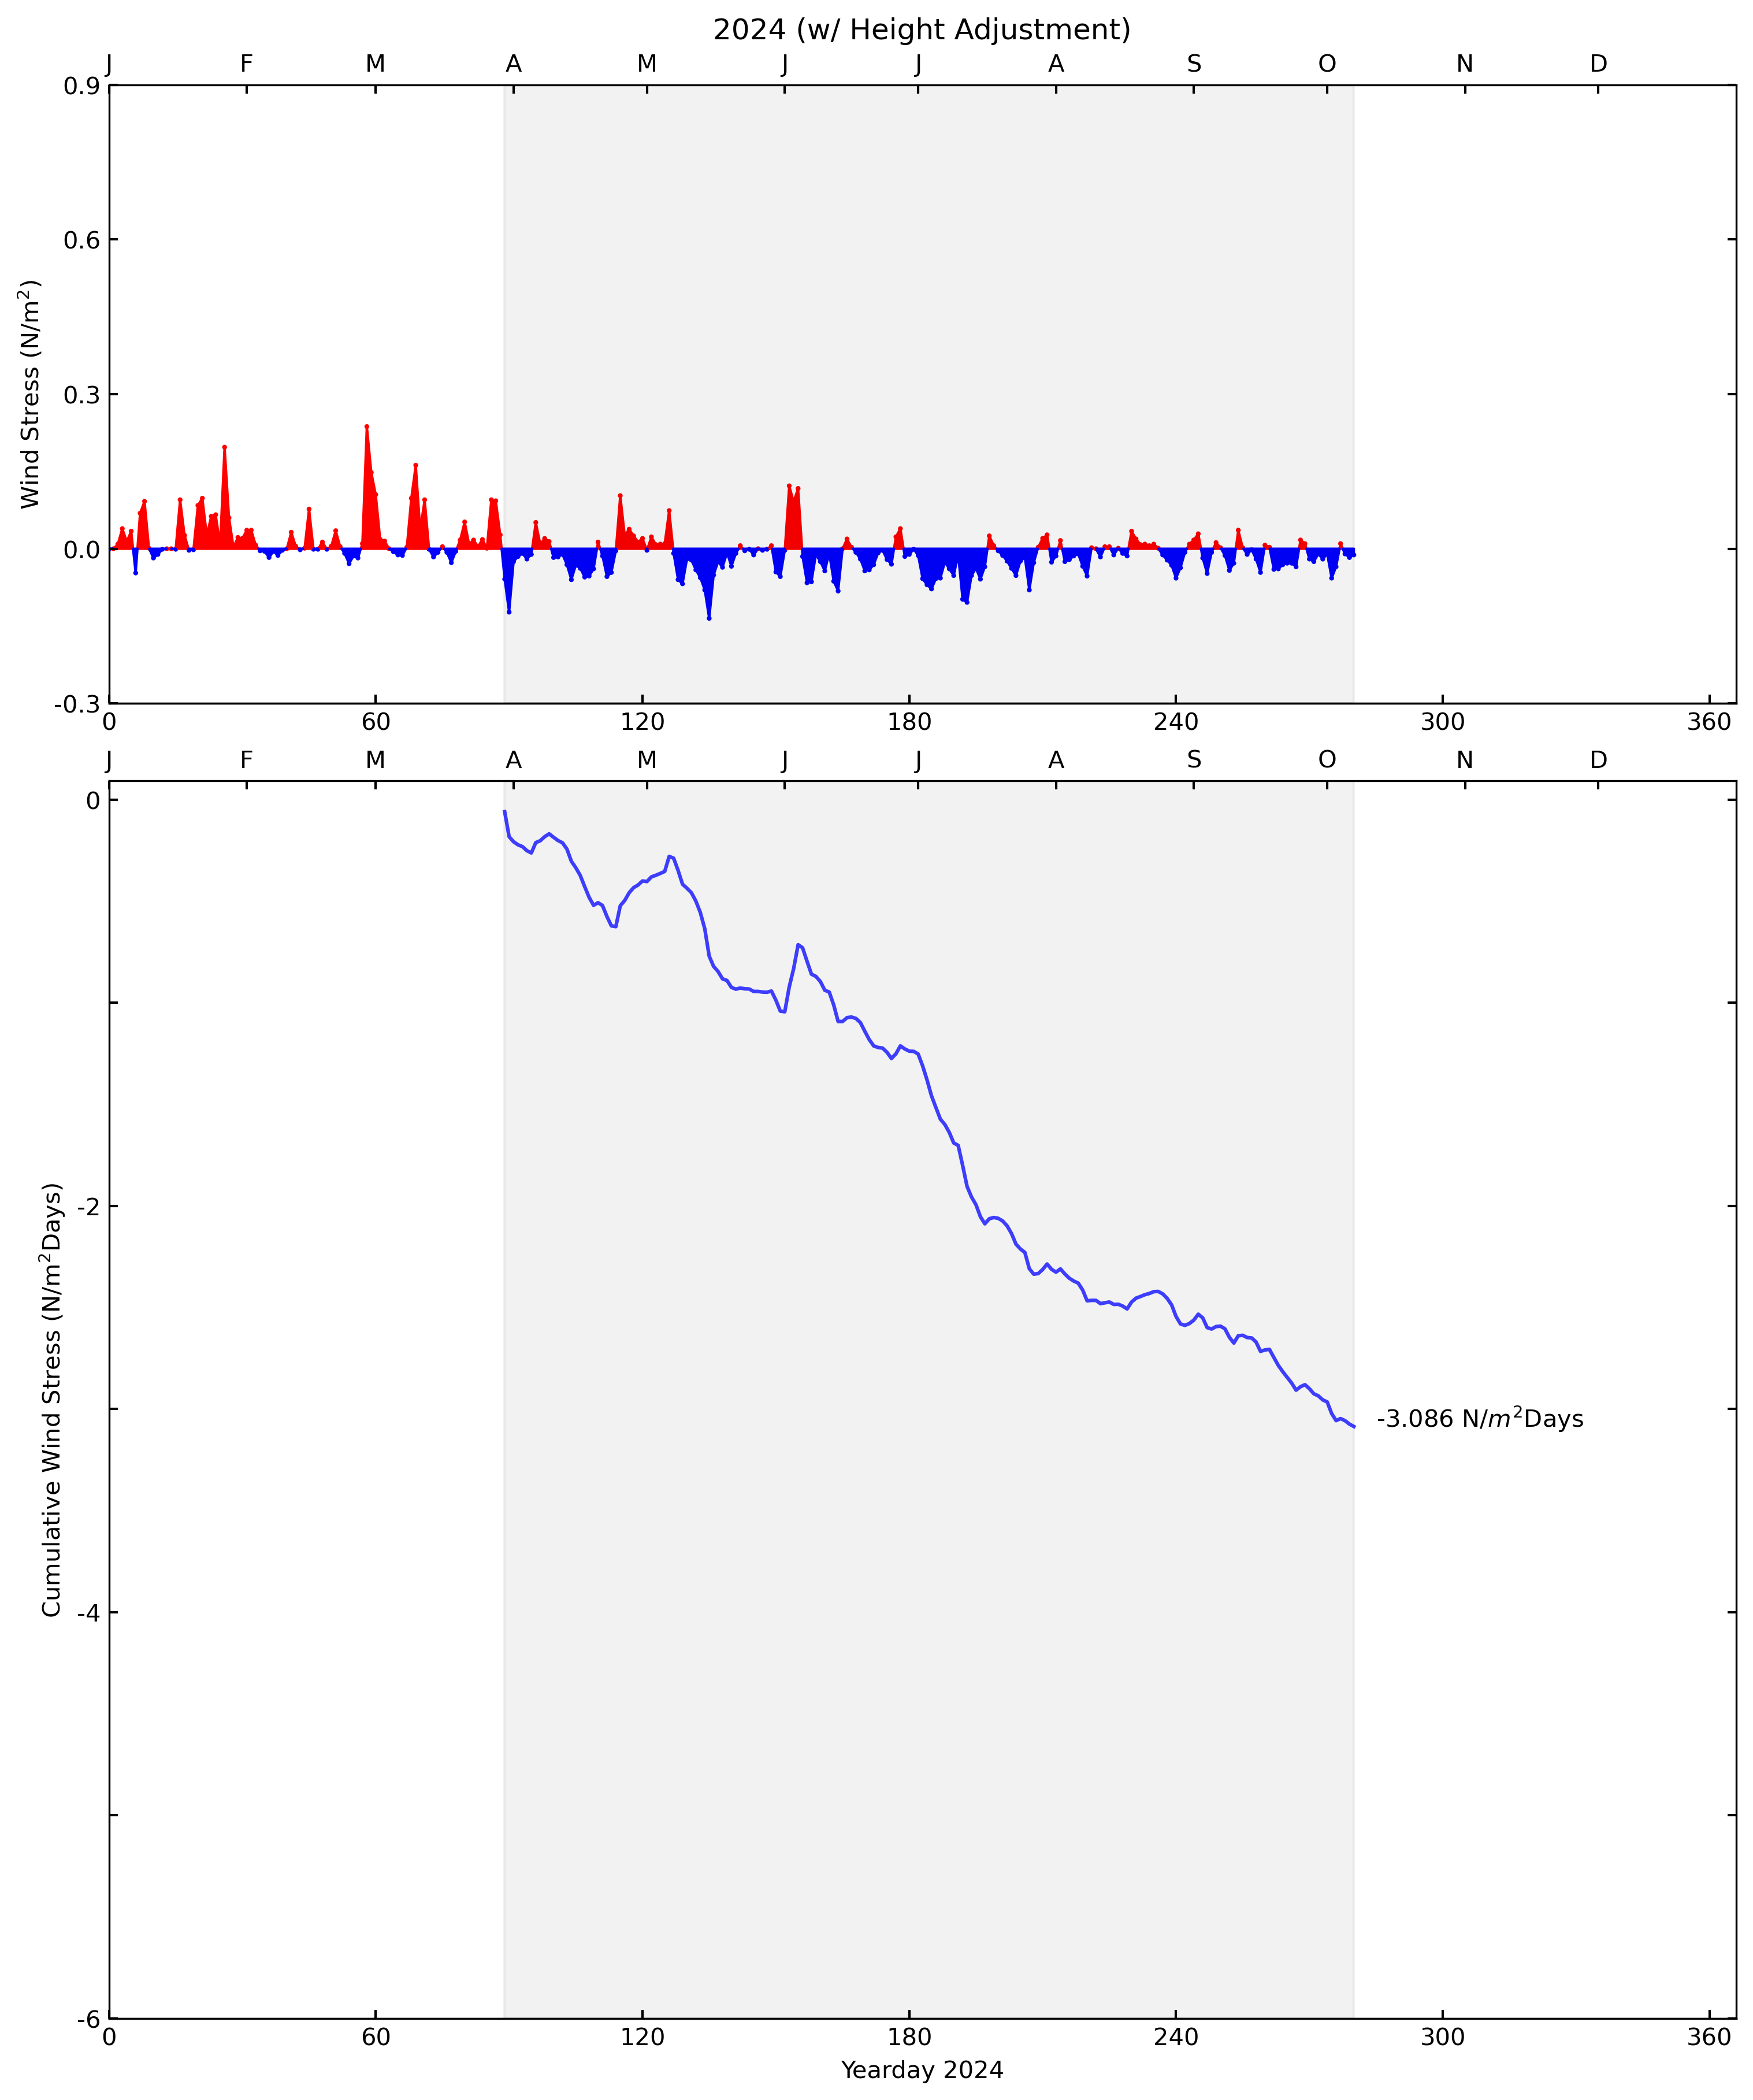

In [40]:
fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                               ['lower', 'lower', 'lower'],
                                     ['lower', 'lower', 'lower']],
                              figsize=(10, 12), layout="constrained", dpi=300)

colors = c=np.where(stress_w_height<0, 'b', 'r')
ax['upper'].scatter(ds.index, stress_w_height, c=colors, s=1)

# Fill the area under the curve
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height >= 0), interpolate=True, color='r', alpha=1)
ax['upper'].fill_between(ds.index, stress_w_height, where=(stress_w_height < 0), interpolate=True, color='b', alpha=1)

ax['upper'].set_xticklabels('')
ax['upper'].set_xticks((datetime(2024,1,1), datetime(2024,2,1), datetime(2024,3,1), datetime(2024,4,1), datetime(2024,5,1), datetime(2024,6,1), datetime(2024,7,1), 
            datetime(2024,8,1), datetime(2024,9,1), datetime(2024,10,1), datetime(2024,11,1), datetime(2024,12,1)))
ax['upper'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['upper'].set_xlim(datetime(2024,1,1), datetime(2025,1,1))
ax['upper'].xaxis.set_label_position('top') 
ax['upper'].xaxis.tick_top()
ax['upper'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax['upper'].secondary_xaxis(location=0)
sec.set_xticks([datetime(2024,1,1), datetime(2024,3,1), datetime(2024,4,30), datetime(2024,6,29), datetime(2024,8,28), datetime(2024,10,27), datetime(2024,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_ylim(-0.3, 0.9)

ax['upper'].set_ylabel(r'Wind Stress (N/m$^2$)')
ax['upper'].set_title('2024 (w/ Height Adjustment)')

ax['lower'].plot(new_time2, cumulative_sum_adj, c='b', alpha=0.75)
ax['lower'].set_xticklabels('')
ax['lower'].set_xticks((datetime(2024,1,1), datetime(2024,2,1), datetime(2024,3,1), datetime(2024,4,1), datetime(2024,5,1), datetime(2024,6,1), datetime(2024,7,1), 
            datetime(2024,8,1), datetime(2024,9,1), datetime(2024,10,1), datetime(2024,11,1), datetime(2024,12,1)))
ax['lower'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['lower'].set_xlim(datetime(2024,1,1), datetime(2025,1,1))
ax['lower'].xaxis.set_label_position('top') 
ax['lower'].xaxis.tick_top()
ax['lower'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')
ax['lower'].set_yticks((0, -1, -2, -3, -4, -5, -6))
ax['lower'].set_yticklabels(('0', '', '-2', '', '-4', '', '-6'))

sec2 = ax['lower'].secondary_xaxis(location=0)
sec2.set_xticks([datetime(2024,1,1), datetime(2024,3,1), datetime(2024,4,30), datetime(2024,6,29), datetime(2024,8,28), datetime(2024,10,27), datetime(2024,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec2.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].axvspan(xmin=datetime(2024,3,30), xmax=datetime(2024,10,7), color='k', alpha=0.05)
ax['lower'].axvspan(xmin=datetime(2024,3,30), xmax=datetime(2024,10,7), color='k', alpha=0.05)

ax['lower'].set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
sec2.set_xlabel(r'Yearday 2024')

ax['lower'].text((new_time2.max() + timedelta(days=5)), cumulative_sum_adj.min(), cumsum_min_adj + ' ' + r'N/$m^2$Days')

## Plots (raw)

Text(0.5, 1.0, '2024')

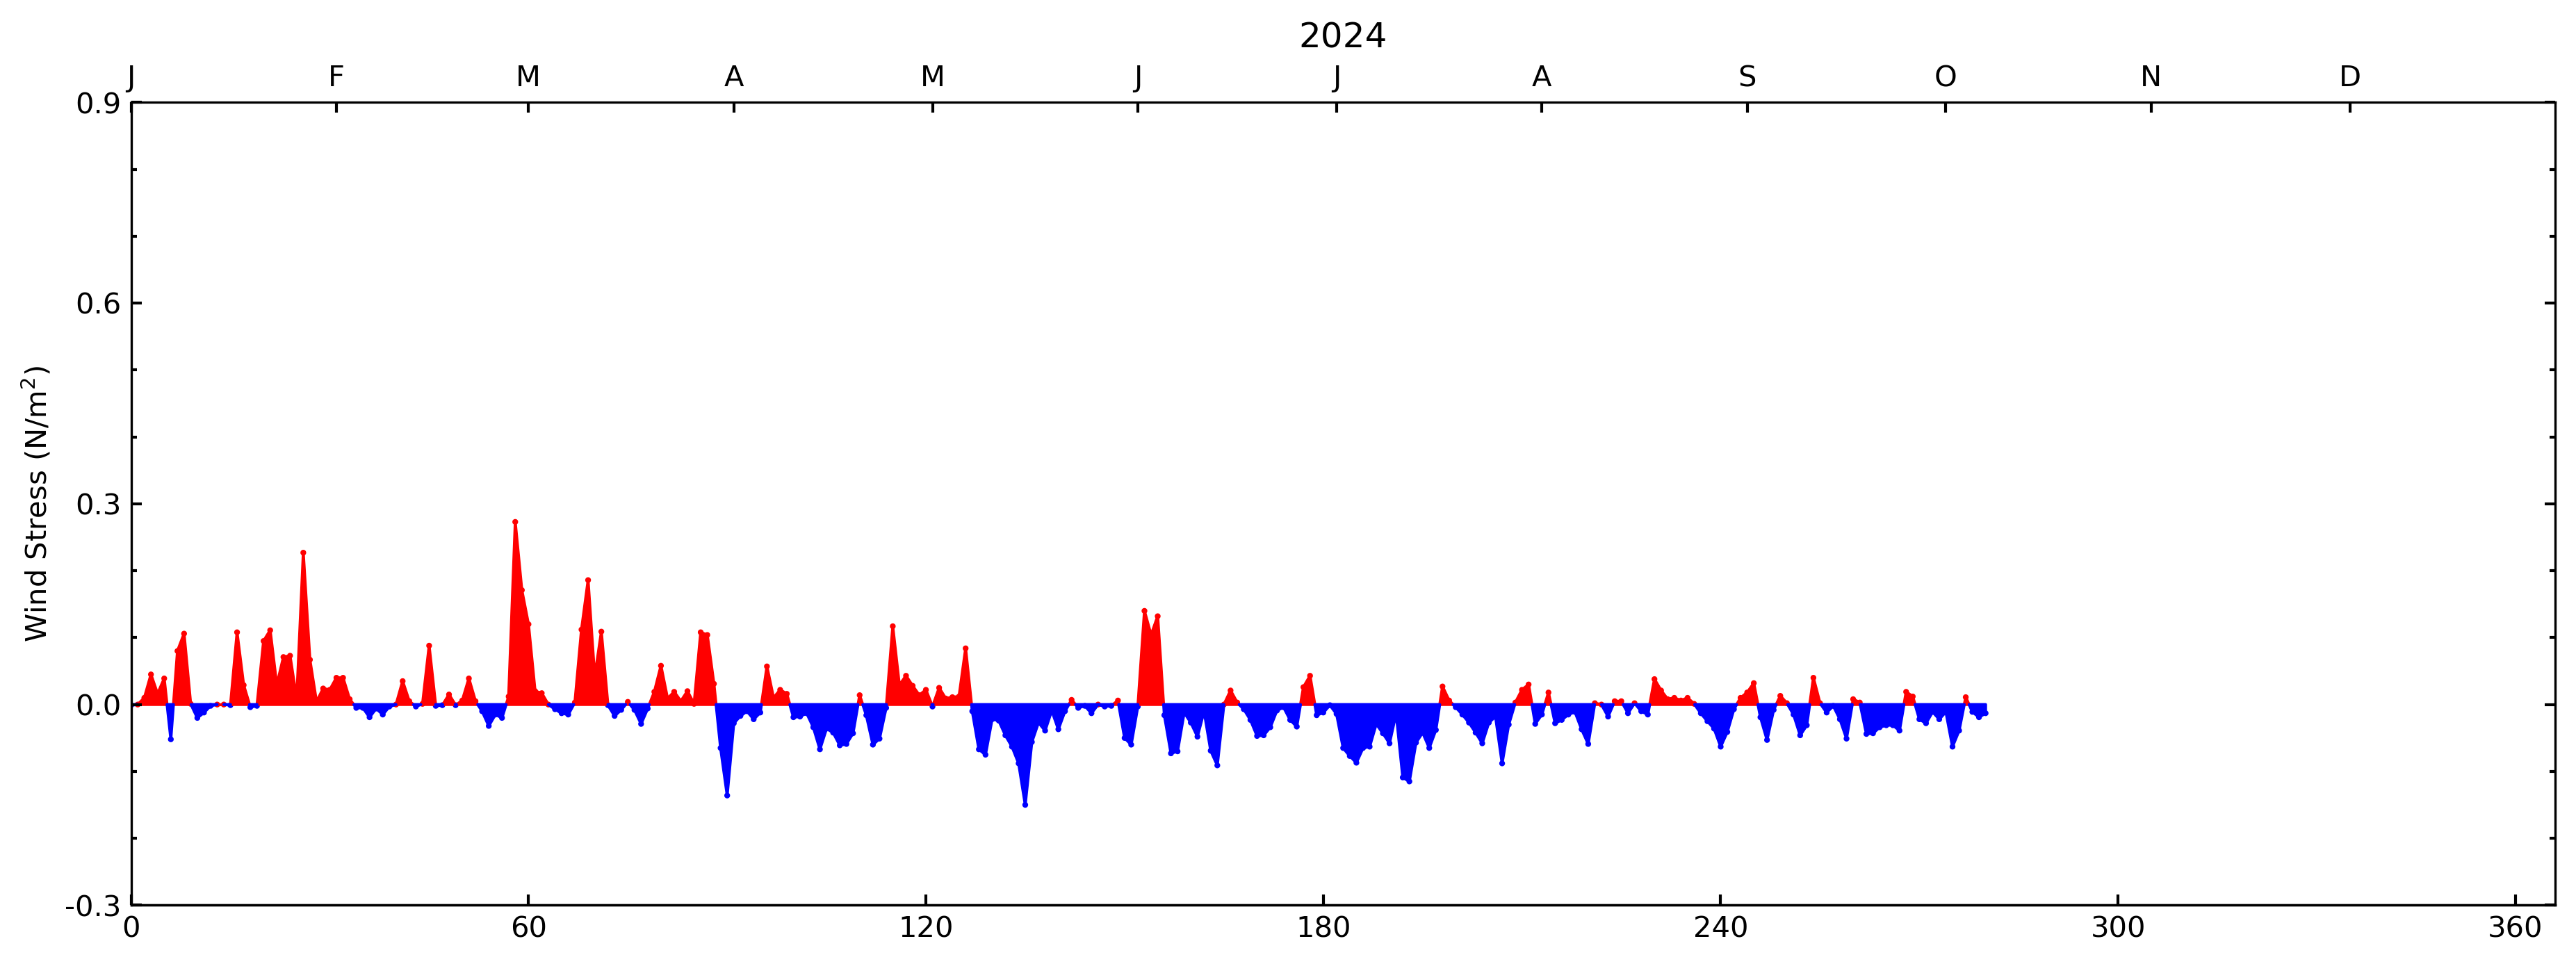

In [41]:
fig, ax = plt.subplots(figsize=(15,5), dpi=300)

colors = c=np.where(stress_raw<0, 'b', 'r')
ax.scatter(ds.index, stress_raw, c=colors, s=1)

# Fill the area under the curve
ax.fill_between(ds.index, stress_raw, where=(stress_raw >= 0), interpolate=True, color='r', alpha=1)
ax.fill_between(ds.index, stress_raw, where=(stress_raw < 0), interpolate=True, color='b', alpha=1)

ax.set_xticklabels('')
ax.set_xticks((datetime(2024,1,1), datetime(2024,2,1), datetime(2024,3,1), datetime(2024,4,1), datetime(2024,5,1), datetime(2024,6,1), datetime(2024,7,1), 
            datetime(2024,8,1), datetime(2024,9,1), datetime(2024,10,1), datetime(2024,11,1), datetime(2024,12,1)))
ax.set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax.set_xlim(datetime(2024,1,1), datetime(2025,1,1))
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([datetime(2024,1,1), datetime(2024,3,1), datetime(2024,4,30), datetime(2024,6,29), datetime(2024,8,28), datetime(2024,10,27), datetime(2024,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax.set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_yticks((-0.2, -0.1, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8), minor=True)
ax.set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax.set_ylim(-0.3, 0.9)

ax.set_ylabel(r'Wind Stress (N/m$^2$)')
ax.set_title('2024')

In [42]:
# Correctly filter the time range
start_date = np.datetime64('2024-03-30T00:00:00.000000000')
end_date = np.datetime64('2024-10-07T00:00:00.000000000')

mask = np.logical_and(ds.index >= start_date, ds.index <= end_date)

new_time2_raw = ds.index[mask]
new_vcomp_N2_raw = stress_raw[mask]
cumulative_sum_raw = (np.cumsum(new_vcomp_N2_raw))

cumsum_min_raw = cumulative_sum_raw.min()
cumsum_min_raw = round(cumsum_min_raw, 3)
cumsum_min_raw = str(cumsum_min_raw)

print(cumsum_min_raw)

-3.397


Text(0.5, 1.0, '2024')

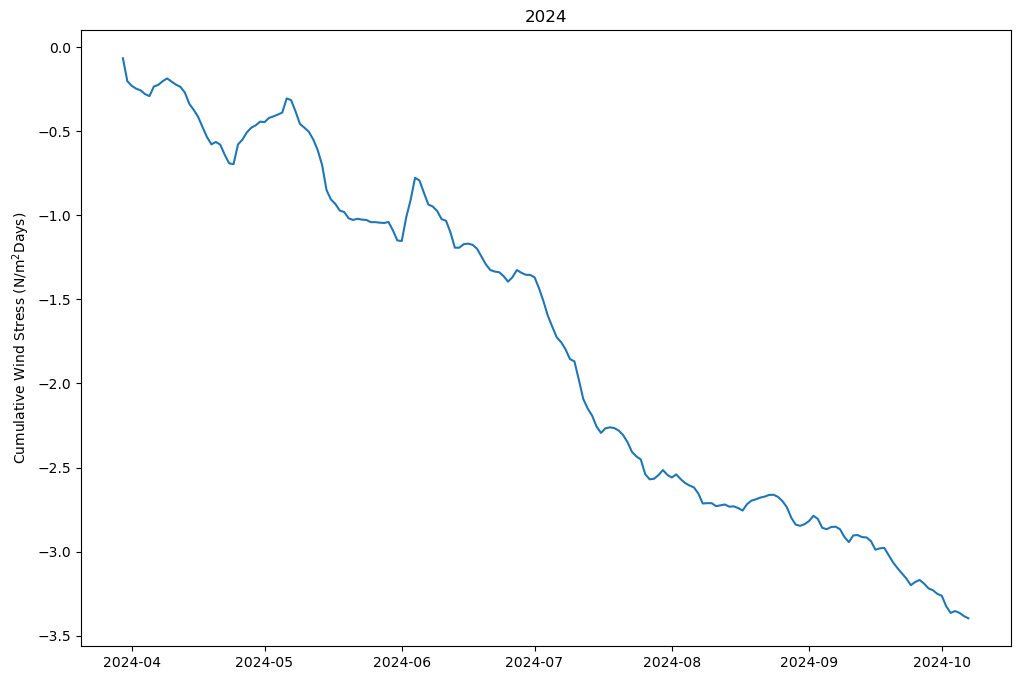

In [43]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(new_time2_raw, cumulative_sum_raw)

ax.set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
ax.set_title('2024')

Text(2024-10-12 00:00:00, -3.397000000000002, '-3.397 N/$m^2$Days')

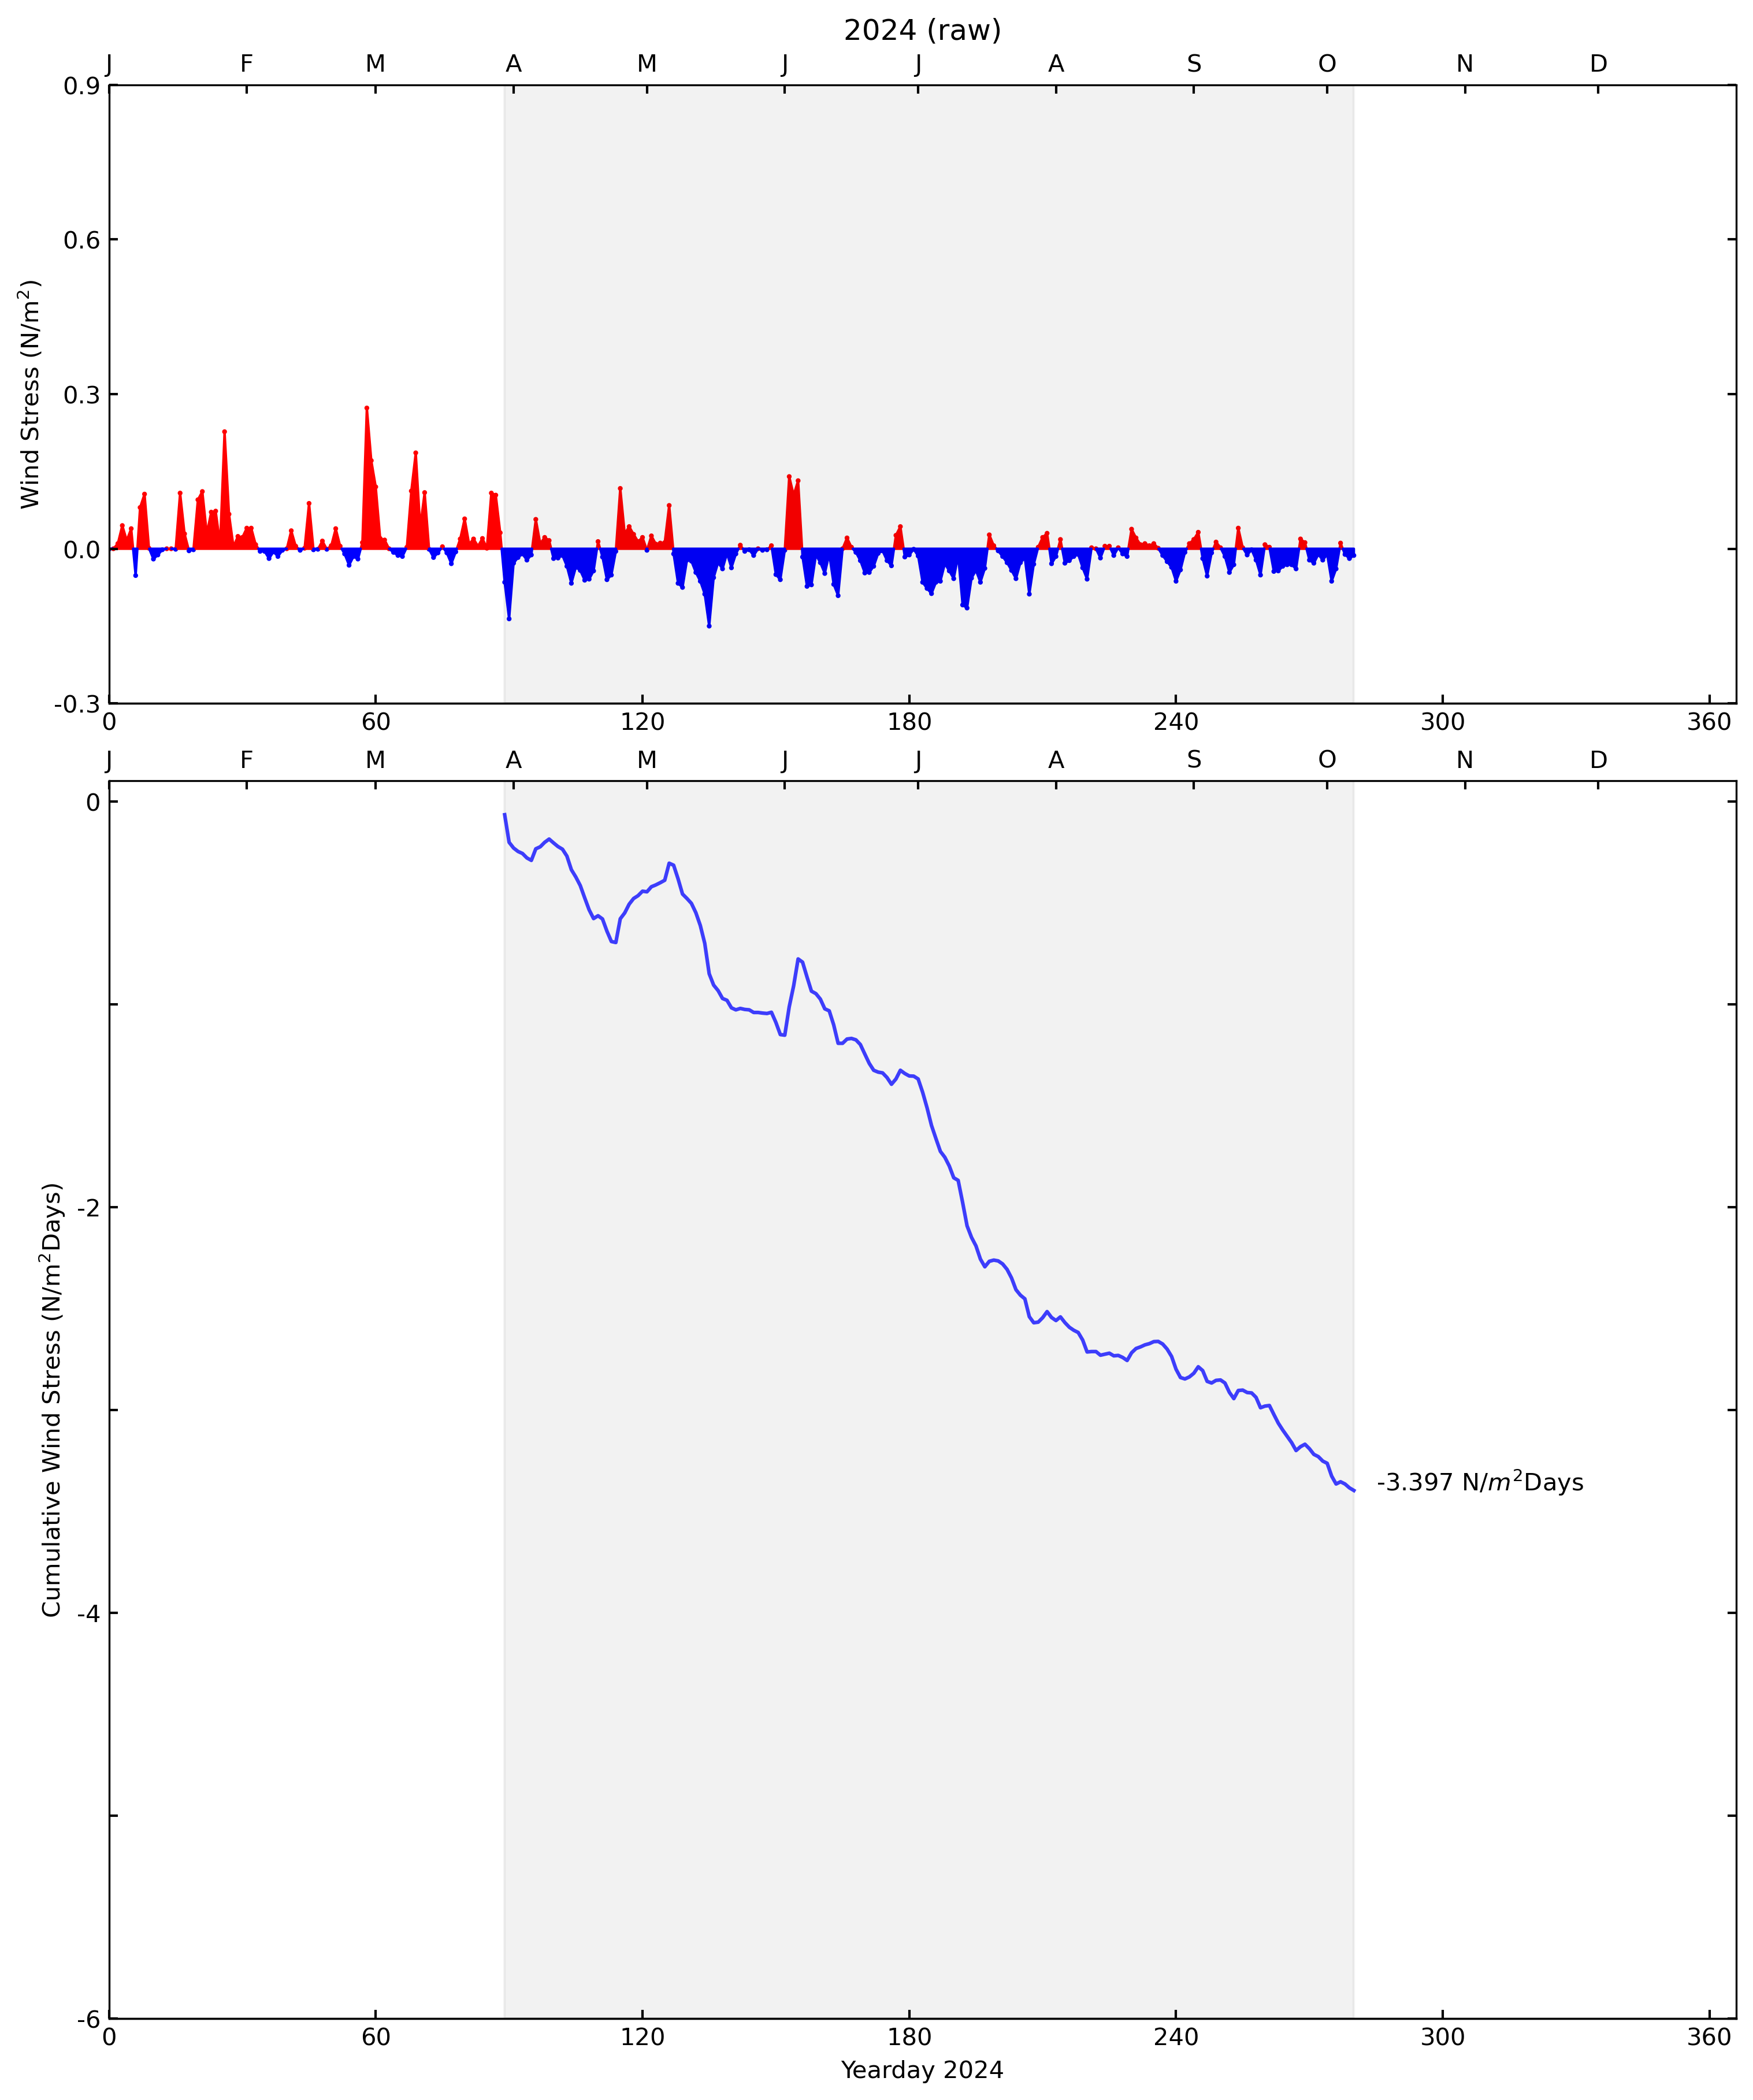

In [44]:
fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                               ['lower', 'lower', 'lower'],
                                     ['lower', 'lower', 'lower']],
                              figsize=(10, 12), layout="constrained", dpi=300)

colors = c=np.where(stress_raw<0, 'b', 'r')
ax['upper'].scatter(ds.index, stress_raw, c=colors, s=1)

# Fill the area under the curve
ax['upper'].fill_between(ds.index, stress_raw, where=(stress_raw >= 0), interpolate=True, color='r', alpha=1)
ax['upper'].fill_between(ds.index, stress_raw, where=(stress_raw < 0), interpolate=True, color='b', alpha=1)

ax['upper'].set_xticklabels('')
ax['upper'].set_xticks((datetime(2024,1,1), datetime(2024,2,1), datetime(2024,3,1), datetime(2024,4,1), datetime(2024,5,1), datetime(2024,6,1), datetime(2024,7,1), 
            datetime(2024,8,1), datetime(2024,9,1), datetime(2024,10,1), datetime(2024,11,1), datetime(2024,12,1)))
ax['upper'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['upper'].set_xlim(datetime(2024,1,1), datetime(2025,1,1))
ax['upper'].xaxis.set_label_position('top') 
ax['upper'].xaxis.tick_top()
ax['upper'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')

sec = ax['upper'].secondary_xaxis(location=0)
sec.set_xticks([datetime(2024,1,1), datetime(2024,3,1), datetime(2024,4,30), datetime(2024,6,29), datetime(2024,8,28), datetime(2024,10,27), datetime(2024,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].set_yticks((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_yticklabels((-0.3, 0.0, 0.3, 0.6, 0.9))
ax['upper'].set_ylim(-0.3, 0.9)

ax['upper'].set_ylabel(r'Wind Stress (N/m$^2$)')
ax['upper'].set_title('2024 (raw)')

ax['lower'].plot(new_time2_raw, cumulative_sum_raw, c='b', alpha=0.75)
ax['lower'].set_xticklabels('')
ax['lower'].set_xticks((datetime(2024,1,1), datetime(2024,2,1), datetime(2024,3,1), datetime(2024,4,1), datetime(2024,5,1), datetime(2024,6,1), datetime(2024,7,1), 
            datetime(2024,8,1), datetime(2024,9,1), datetime(2024,10,1), datetime(2024,11,1), datetime(2024,12,1)))
ax['lower'].set_xticklabels(('J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'))
ax['lower'].set_xlim(datetime(2024,1,1), datetime(2025,1,1))
ax['lower'].xaxis.set_label_position('top') 
ax['lower'].xaxis.tick_top()
ax['lower'].tick_params(width=1, top=True, right=True, bottom=False, direction='in', which='both')
ax['lower'].set_yticks((0, -1, -2, -3, -4, -5, -6))
ax['lower'].set_yticklabels(('0', '', '-2', '', '-4', '', '-6'))

sec2 = ax['lower'].secondary_xaxis(location=0)
sec2.set_xticks([datetime(2024,1,1), datetime(2024,3,1), datetime(2024,4,30), datetime(2024,6,29), datetime(2024,8,28), datetime(2024,10,27), datetime(2024,12,26)], labels=['0', '60', '120', '180', '240', '300', '360'])
sec2.tick_params(width=1, top=False, right=False, bottom=True, direction='in', which='both')

ax['upper'].axvspan(xmin=datetime(2024,3,30), xmax=datetime(2024,10,7), color='k', alpha=0.05)
ax['lower'].axvspan(xmin=datetime(2024,3,30), xmax=datetime(2024,10,7), color='k', alpha=0.05)

ax['lower'].set_ylabel(r'Cumulative Wind Stress (N/m$^2$Days)')
sec2.set_xlabel(r'Yearday 2024')

ax['lower'].text((new_time2_raw.max() + timedelta(days=5)), cumulative_sum_raw.min(), cumsum_min_raw + ' ' + r'N/$m^2$Days')